# I. Data Cleaning for Project 2 ML (OpenFoodFacts)

## Contents

1) <a href='#Sec.1'>Preparing the data for cleaning</a>
1) <a href='#Sec.2'>Columns Cleaning</a>
    1) <a href='#Sec.2.1'>Features with no values</a>
    1) <a href='#Sec.2.2'>Features with missing value factor being more than certain threshold</a>
    1) <a href='#Sec.2.3'>Features that are not important for the application</a>
1) <a href='#Sec.3'>Rows Cleaning for Quantitative Columns</a>
    1) <a href='#Sec.3.1'>Deleting products with no nutritional contents</a>
    1) <a href='#Sec.3.2'>Removing rows with negative values</a>
    1) <a href='#Sec.3.3'>Removing rows with wrong nutritional values</a>
    1) <a href='#Sec.3.4'>Removing rows with wrong energy values</a>
    1) <a href='#Sec.3.5'>Removing rows with wrong nutri and Nova score</a>
    1) <a href='#Sec.3.6'>Final check on all numerical columns</a>
1) <a href='#Sec.4'>Rows Cleaning for Qualitative Columns</a>
    1) <a href='#Sec.4.1'>Cleaning barcode and product_name</a>
    1) <a href='#Sec.4.2'>Duplicate treatment</a>
    1) <a href='#Sec.4.3'>Removing rows with wrong nutriscore grade</a>
1) <a href='#Sec.5'>Treating missing values</a>
    1) <a href='#Sec.5.1'>Treating missing values in quantitative columns</a>
    1) <a href='#Sec.5.2'>Treating missing values in qualitative columns</a>
1) <a href='#Sec.6'>Extracting the cleaned data</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import missingno as msno
import os

from stdnum.ean import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import neighbors
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

sns.set()

Opening the data file, and separating the fields using tabs.

In [2]:
OFF_data = pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t', low_memory=False)
initial_nbr_rows = OFF_data.shape[0]
initial_nbr_columns = OFF_data.shape[1]
print('The size of the table is', initial_nbr_rows, 'rows, and', initial_nbr_columns, 'columns.')

The size of the table is 2696087 rows, and 197 columns.


## <font id='Sec.1'> 1. Preparing the data for cleaning.
- Getting an overview of the data, checking the type of columns and fixing some if needed.
- Checking the None or unknown values and replacing them with NaN.

In [3]:
# To display all columnswhen needed
pd.set_option('display.max_columns', None)

# Function to add infos about the type and null values to .describe function
def df_description(df):
    # General description 
    description = df.describe(include='all', datetime_is_numeric=True)

    # Types and content of the columns
    description_type = pd.DataFrame(df.dtypes, columns=['type']).T
    number_null = (df.shape[0] - description.loc["count"].T)
    percentage_null = (df.shape[0] - description.loc["count"].T)*100/df.shape[0]
    description_null = pd.DataFrame([number_null, percentage_null], index=['number null', 'percentage null'])

    # Concatenate general, type and null stats
    description = pd.concat([description_type, description_null, description])
    return description

In [4]:
print('Percentage of NaN in the dataset equal to',
      sum(OFF_data.isna().sum() / OFF_data.shape[0]*100) / OFF_data.shape[1])
df_description(OFF_data)

percentage of NaN in the dataset equal to 78.44427586564781


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity,packaging,packaging_tags,packaging_en,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,ingredients_tags,ingredients_analysis_tags,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,brand_owner,ecoscore_score,ecoscore_grade,nutrient_levels_tags,product_quantity,owner,data_quality_errors_tags,unique_scans_n,popularity_tags,completeness,last_image_t,last_image_datetime,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kj_100g,energy-kcal_100g,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,-butyric-acid_100g,-caproic-acid_100g,-caprylic-acid_100g,-capric-acid_100g,-lauric-acid_100g,-myristic-acid_100g,-palmitic-acid_100g,-stearic-acid_100g,-arachidic-acid_100g,-behenic-acid_100g,-lignoceric-acid_100g,-cerotic-acid_100g,-montanic-acid_100g,-melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,-alpha-linolenic-acid_100g,-eicosapentaenoic-acid_100g,-docosahexaenoic-acid_100g,omega-6-fat_100g,-linoleic-acid_100g,-arachidonic-acid_100g,-gamma-linolenic-acid_100g,-dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,-oleic-acid_100g,-elaidic-acid_100g,-gondoic-acid_100g,-mead-acid_100g,-erucic-acid_100g,-nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,-sucrose_100g,-glucose_100g,-fructose_100g,-lactose_100g,-maltose_100g,-maltodextrins_100g,starch_100g,polyols_100g,-erythritol_100g,fiber_100g,soluble-fiber_100g,insoluble-fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
type,object,object,object,int64,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,float64,float64,float64,object,object,object,float64,object,float64,object,object,object,object,object,object,object,object,object,float64,object,object,float64,object,object,float64,object,float64,float64,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,

**Transforming the format of created_datetime and last_modified_datetime columns to time. Dropping the created_t and last_modified_t columns.**

In [5]:
OFF_data['created_datetime'] = pd.to_datetime(OFF_data['created_t'], unit='s')
OFF_data['last_modified_datetime'] = pd.to_datetime(OFF_data['last_modified_t'], unit='s')

OFF_data = OFF_data.drop(['created_t', 'last_modified_t'], axis='columns')
print('The size of the table is now', OFF_data.shape[0],
      'rows, and', OFF_data.shape[1], 'columns.')

The size of the table is now 2696087 rows, and 195 columns.


**Checking for the presence of none or unknown values. Replacing them with NaN.**

In [6]:
print('Number of rows containing None value equal to',
      OFF_data[OFF_data.eq('None').any(axis=1)].shape[0])
print('Number of rows containing unknown value equal to',
      OFF_data[OFF_data.eq('unknown').any(axis=1)].shape[0])
OFF_data[(OFF_data == 'en:none') | (OFF_data == 'None') | (OFF_data == 'unknown')] = np.nan
print('After Replacing those None and unknown values with NaN, the number of rows still containing those value equal to',
      OFF_data[OFF_data.eq('None').any(axis=1) | OFF_data.eq('unknown').any(axis=1)].shape[0])

Number of rows containing None value equal to 1715
Number of rows containing unknown value equal to 2111668
After Replacing those None and unknown values with NaN, the number of rows still containing those value equal to 0


## <font id='Sec.2'> 2. Columns Cleaning
    
- A. We check the columns zero and null sum and if all values are null or zero in a column, we drop that column.
I will define a function called "columns_null_zero" with the task to keep all columns with at least one non zero and non null value.
- B. Then we remove all columns with null factor being more than certain threshold. With the help of Missingno library, we check the null factors graphically using bar plot.
I will define another function called "columns_null_threshold" with the task to keep all columns filled with at least of certain threshold of non_null values.
- C. Finally, we keep only the columns that are useful for the application and the analysis of the data.

### <font id='Sec.2.1'> A. Features with no values
    We check the columns zero and null sum and if all values are null or zero in a column, we drop that column.

In [7]:
# Function to check and remove all columns full of 0 or null values 
def columns_null_zero(df):
    null_zero_df = ((df == 0) | (df.isnull())).sum().reset_index()
    null_zero_df.columns = ['Columns_name', 'Numbers_null_zero']
    print('Number of columns with all values zero or null equal to',
          null_zero_df[null_zero_df['Numbers_null_zero'] == df.shape[0]].shape[0])
    df_reduced = df[list(null_zero_df.loc[null_zero_df['Numbers_null_zero'] != df.shape[0],
                                          'Columns_name'].values)]
    print('After removing the columns with at least one non zero and non null value, the number of columns left =',
          df_reduced.shape[1])
    return df_reduced

In [8]:
OFF_data = columns_null_zero(OFF_data)

Number of columns with all values zero or null equal to 37
After removing the columns with at least one non zero and non null value, the number of columns left = 158


**Using Missingno bar plot to see the null factor in each column.**

In [9]:
# Function to plot multiple bar plot using missingno library and limiting eacg bar plot to maximum 50 columns
def Missingno_bar_plot_multicolumns(df):
    i_max = int(df.shape[1]/50 + 1)
    for i in range(0, i_max):
        i_start = i*50
        i_end = i*50+50
        if i_end > df.shape[1]:
            i_end = df.shape[1]
        msno.bar(df[df.columns[i_start:i_end]], fontsize=11)
        plt.show()

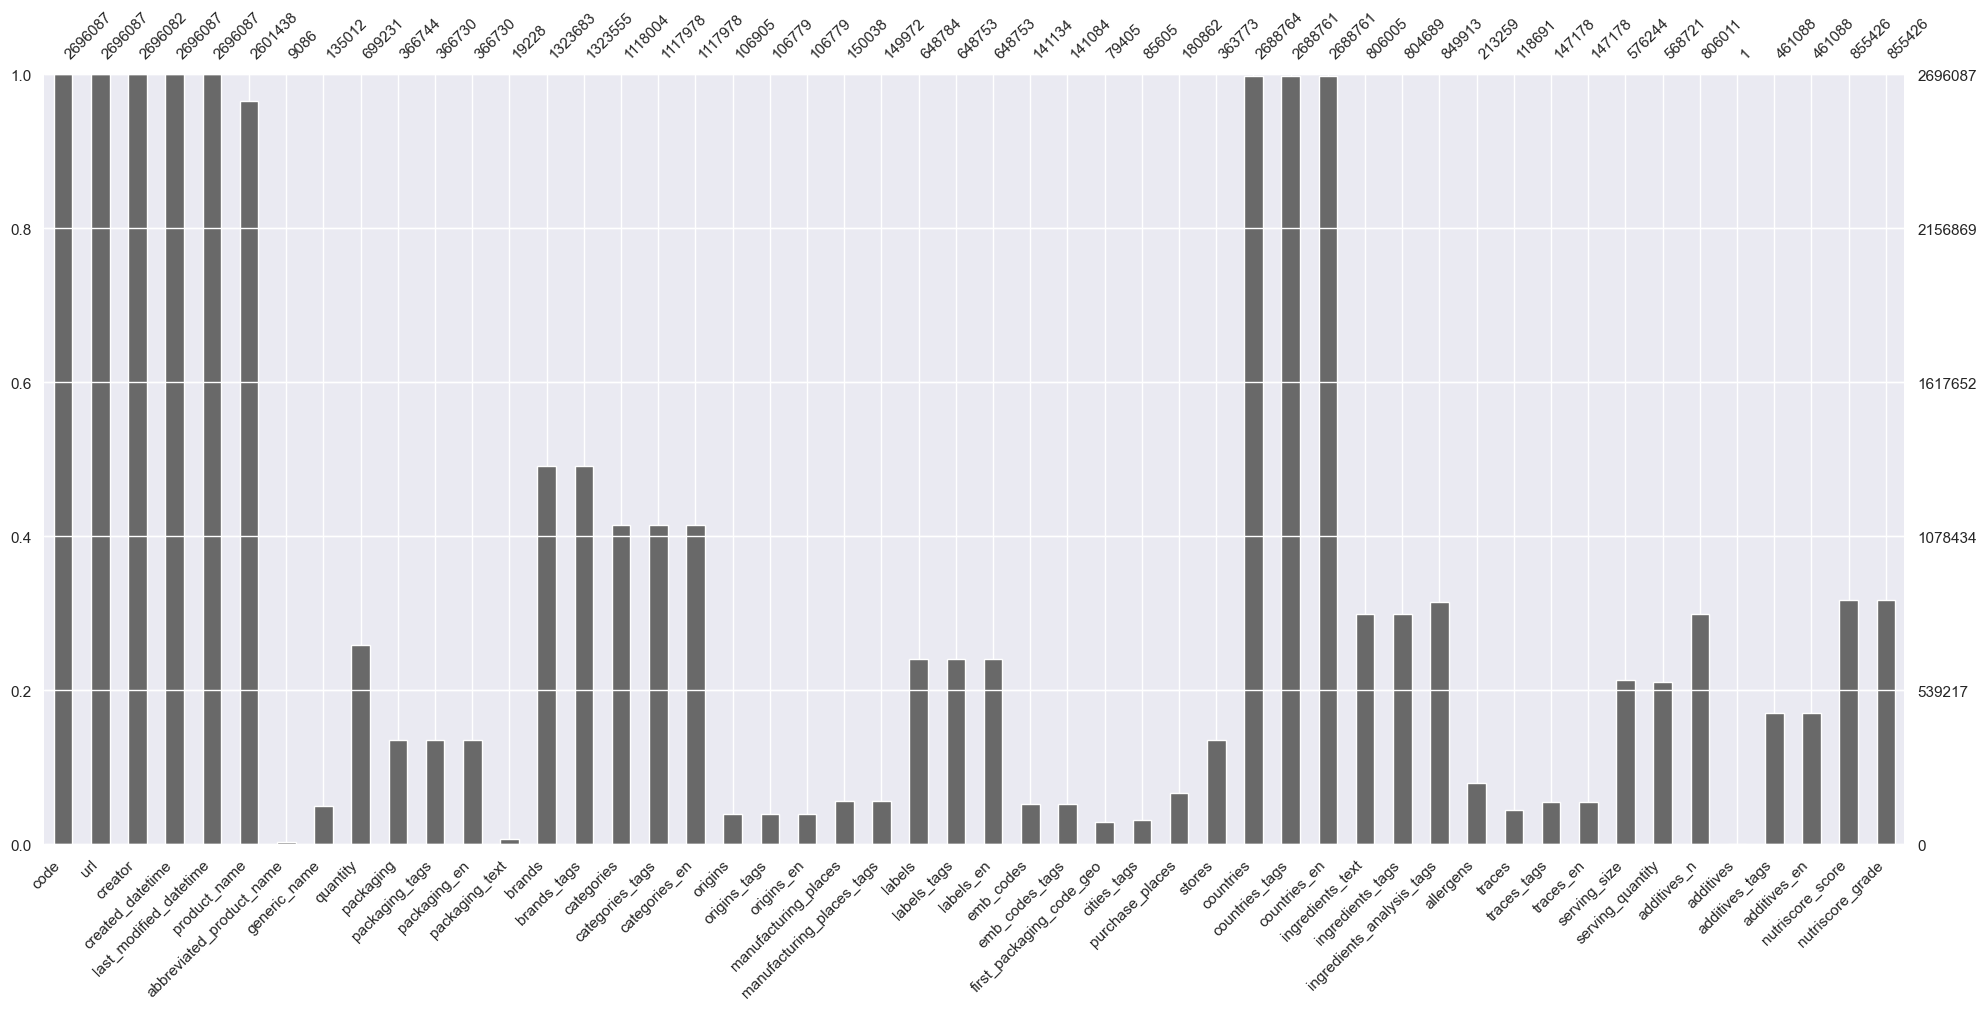

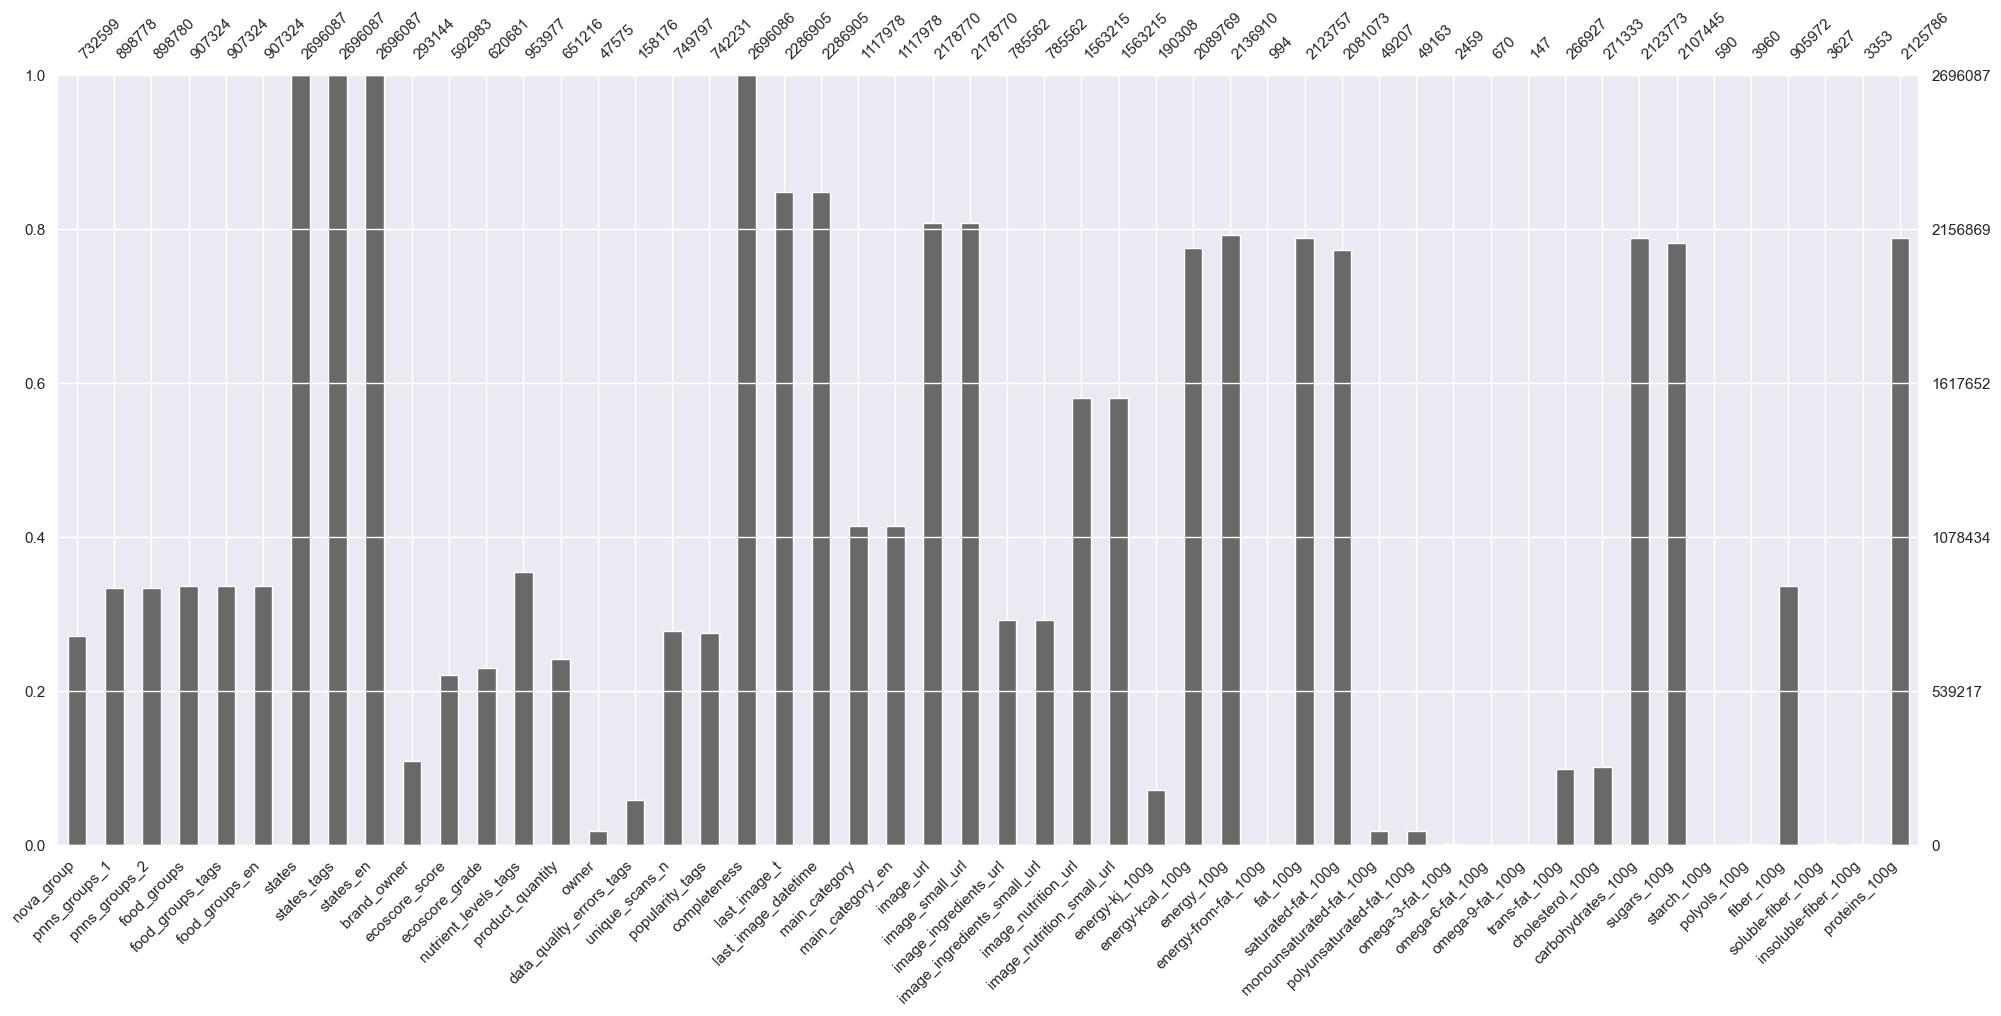

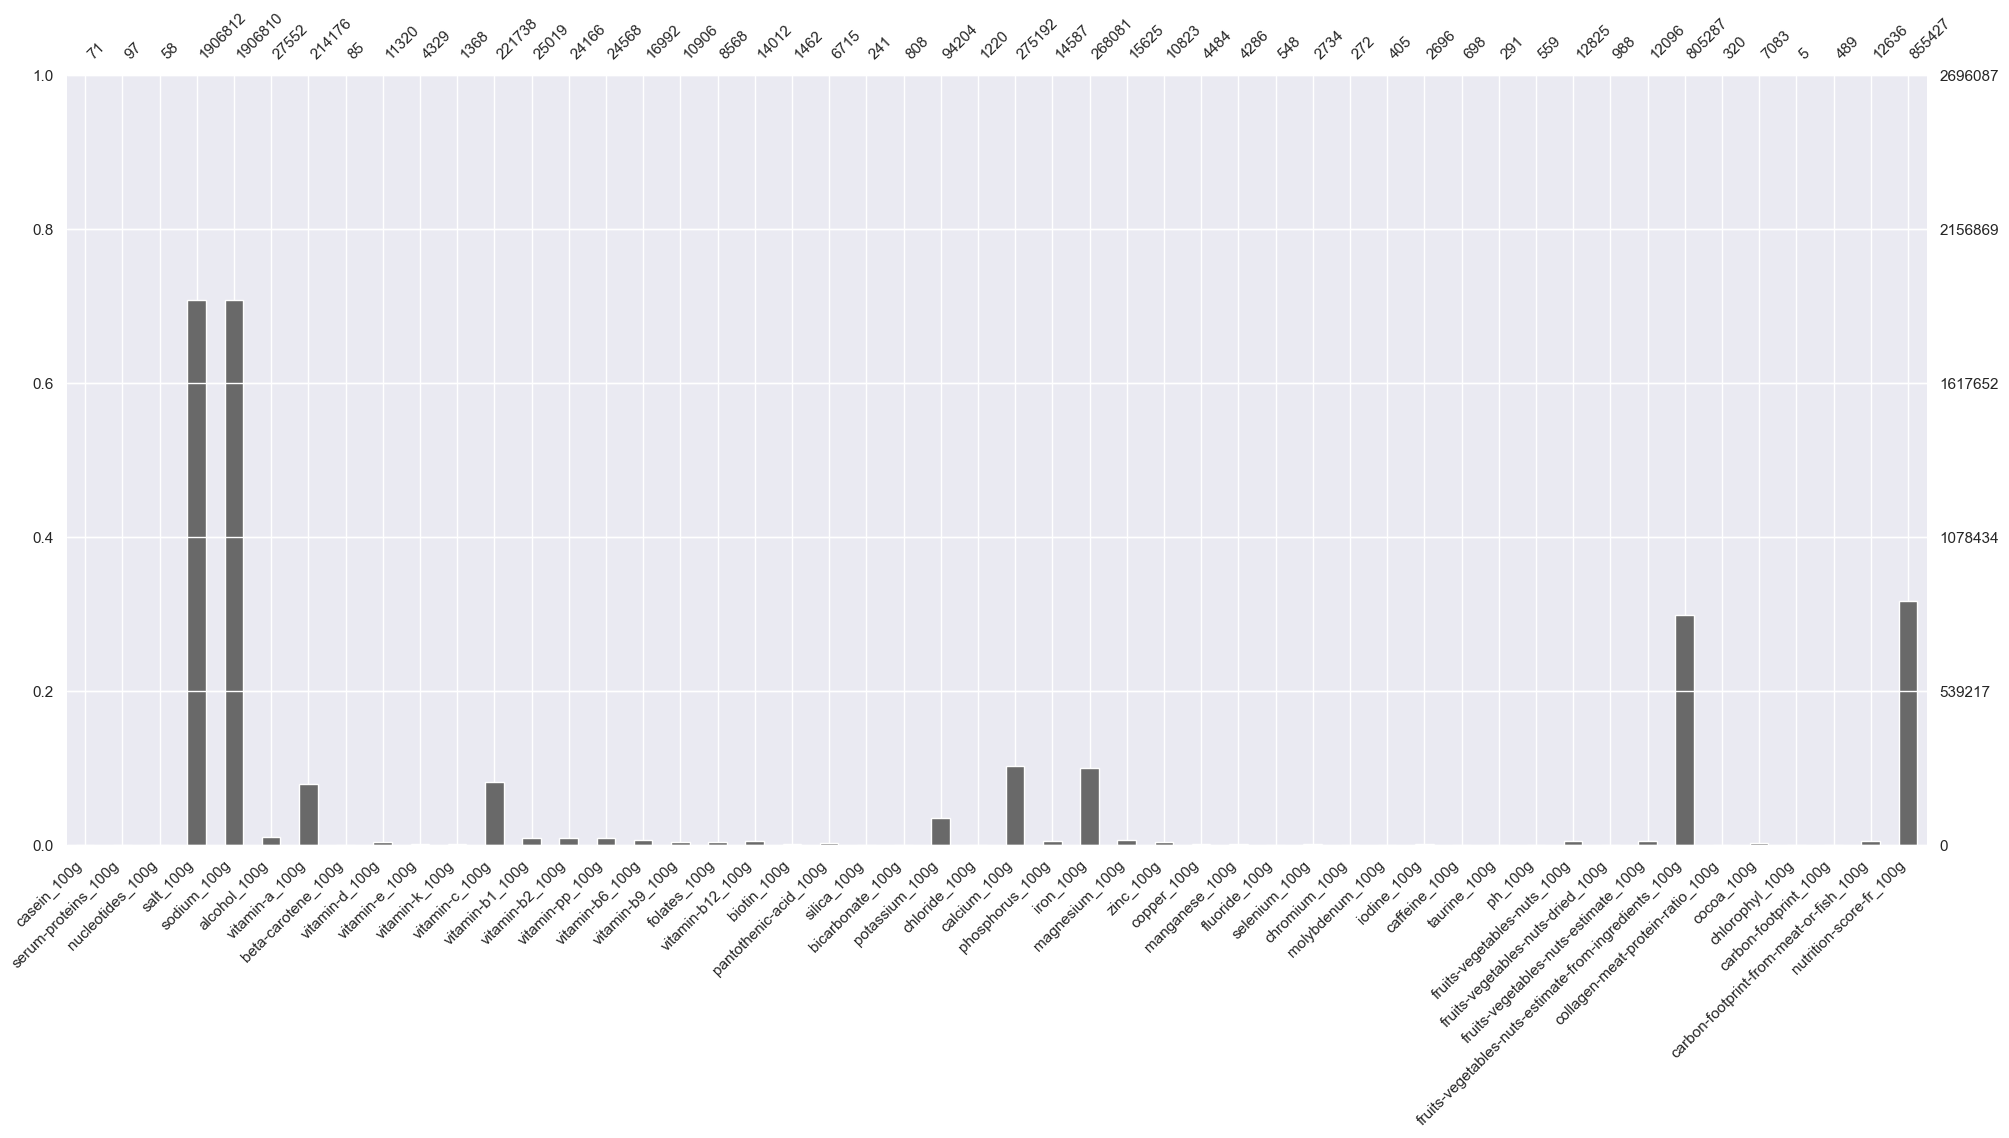

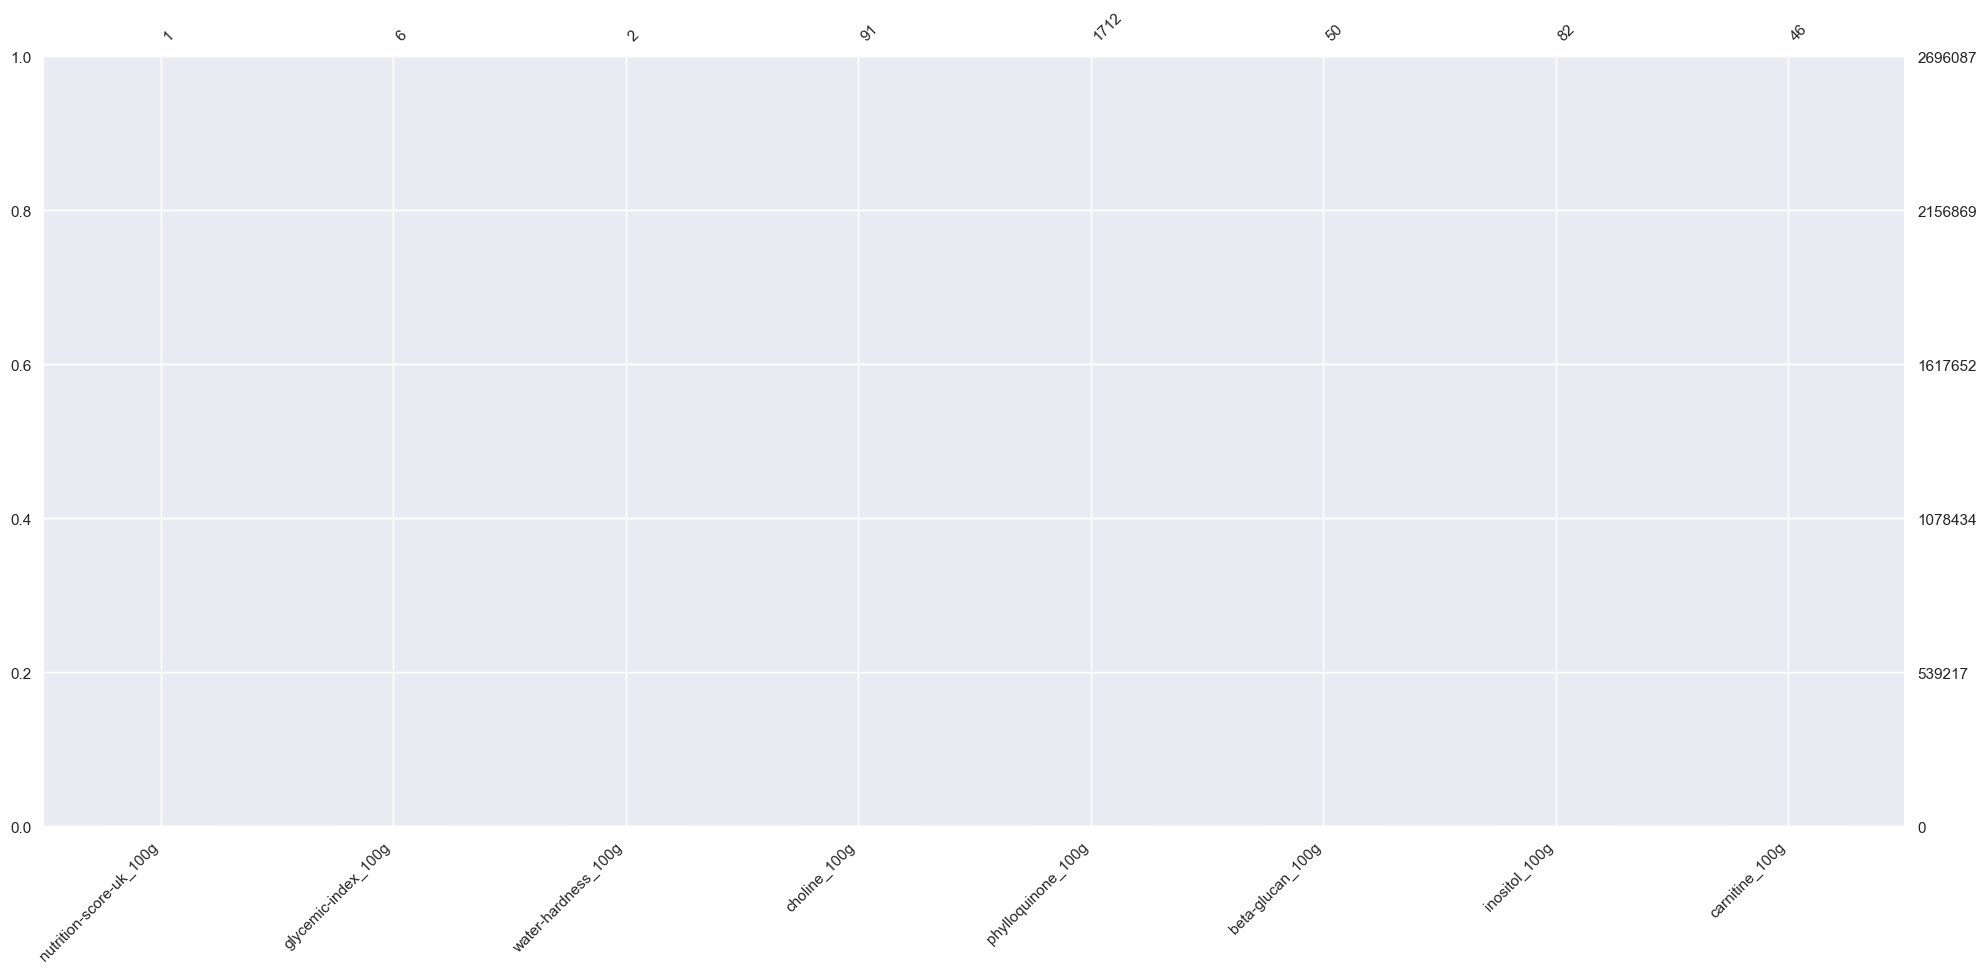

In [10]:
Missingno_bar_plot_multicolumns(OFF_data)

### <font id='Sec.2.2'> B. Features with missing value factor being more than certain threshold

    Checking the bar plots, lot of columns have less than 20% non_null values, we are going to drop those columns.

In [11]:
# Function to check and accept all columns with non_null values at certain threshold
def columns_non_null_threshold(df, accepted_non_null_threshold_in_percentage):
    print('Number of columns filled with at least',
          (100 - accepted_non_null_threshold_in_percentage),
          '% of null value equal to',
          (df.shape[1] - df.dropna(thresh=df.shape[0]*accepted_non_null_threshold_in_percentage/100, axis=1).shape[1]))
    df_reduced = df.dropna(thresh=df.shape[0]*accepted_non_null_threshold_in_percentage/100, axis=1)
    print('After removing those columns, the number of columns left =', df_reduced.shape[1])
    return df_reduced

In [12]:
OFF_data = columns_non_null_threshold(OFF_data, 20)

Number of columns filled with at least 80 % of null value equal to 94
After removing those columns, the number of columns left = 64


### <font id='Sec.2.3'> C. Features that are not important for the application

In [13]:
print('percentage of NaN in the dataset equal to',
      sum(OFF_data.isna().sum() / OFF_data.shape[0]*100) / OFF_data.shape[1])
df_description(OFF_data)

percentage of NaN in the dataset equal to 44.19090634871947


,code,url,creator,created_datetime,last_modified_datetime,product_name,quantity,brands,brands_tags,categories,categories_tags,categories_en,labels,labels_tags,labels_en,countries,countries_tags,countries_en,ingredients_text,ingredients_tags,ingredients_analysis_tags,serving_size,serving_quantity,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,states,states_tags,states_en,ecoscore_score,ecoscore_grade,nutrient_levels_tags,product_quantity,unique_scans_n,popularity_tags,completeness,last_image_t,last_image_datetime,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
type,object,object,object,datetime64[ns],datetime64[ns],object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,float64,object,object,object,object,object,object,object,object,float64,object,object,float64,float64,object,float64,float64,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
number null,0.0,0.0,5.0,0.0,0.0,94649.0,1996856.0,1372404.0,1372532.0,1578083.0,1578109.0,1578109.0,2047303.0,2047334.0,2047334.0,7323.0,7326.0,7326.0,1890082.0,1891398.0,1846174.0,2119843.0,2127366.0,1890076.0,1840661.0,1840661.0,1963488.0,1797309.0,1797307.0,1788763.0,1788763.0,1788763.0,0.0,0.0,0.0,2103104.0,2075406.0,1742110.0,2044871.0,1946290.0,1953856.0,1.0,409182.0,409182.0,1578109.0,1578109.0,517317.0,517317.0,1910525.0,1910525.0,1132872.0,1132872.0,606318.0,559177.0,572330.0,615014.0,572314.0,588642.0,1790115.0,570301.0,789275.0,789277.0,1890800.0,1840660.0
percentage null,0.0,0.0,0.000185,0.0,0.0,3.510606,74.064969,50.90355,50.908298,58.532347,58.533311,58.533311,75.936088,75.937238,75.937238,0.271616,0.271727,0.271727,70.104637,70.153448,68.476054,78.626654,78.905688,70.104414,68.271573,68.271573,72.827323,66.663613,66.663539,66.346635,66.346635,66.346635,0.0,0.0,0.0,78.005791,76.978451,64.616238,75.845883,72.189436,72.470065,0.000037,15.176884,15.176884,58.533311,58.533311,19.187697,19.187697,70.862884,70.862884,42.019119,42.019119,22.488814,20.740317,21.228173,22.811356,21.227579,21.833198,66.396782,21.152915,29.274834,29.274908,70.131268,68.271536
count,2696087,2696087,2696082,2696087,2696087,2601438,699231,1323683,1323555,1118004,1117978,1117978,648784,648753,648753,2688764,2688761,2688761,806005,804689,849913,576244,568721.0,806011.0,855426.0,855426,732599.0,898778,898780,907324,907324,907324,2696087,2696087,2696087,592983.0,620681,953977,651216.0,749797.0,742231,2696086.0,2286905.0,2286905,1117978,1117978,2178770,2178770,785562,785562,1563215,1563215,2089769.0,2136910.0,2123757.0,2081073.0,2123773.0,2107445.0,905972.0,2125786.0,1906812.0,1906810.0,805287.0,855427.0
unique,2696045,2696053,17855,NaN,NaN,1633313,43897,225764,173312,151070,94498,94490,95896,74026,74020,14026,5671,5671,684735,604502,43,49119,NaN,NaN,NaN,5,NaN,11,41,46,46,46,5079,5079,5079,NaN,6,254,NaN,NaN,169196,NaN,NaN,2269405,39485,39480,2178592,2178592,785522,785522,1563163,1563163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0326496301163,http://world-en.openfoodfacts.org/product/8008...,kiliweb,NaN,NaN,Aceite de oliva virgen extra,500 g,Carrefour,carrefour,Snacks,en:snacks,Snacks,Bio,en:no-gluten,No gluten,France,en:france,France,"Carbonated water, natural flavor.","en:honey,en:added-sugar","en:palm-oil-content-unknown,en:vegan-status-un...",100g,NaN,NaN,NaN,d,NaN,Sugary snacks,Sweets,en:sweets,"en:sugary-snacks,en:sweets","Sugary snacks,Sweets","en:to-be-completed, en:nutrition-facts-complet...","en:to-be-

**The columns that are useful to the application and for further analysis are:**

    'code', 'product_name', 'brands', 'pnns_groups_1', 'pnns_groups_2', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'completeness', 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g'
    
I left the 'energy_100g' and 'completeness' columns because they will be used for checking and cleaning the data, they will be dropped at the end of the cleaning procedure.

In [14]:
print('The actual number of columns in the table equal to', OFF_data.shape[1])
columns_to_keep=['code', 'product_name', 'brands', 'pnns_groups_1', 'pnns_groups_2',
                 'nutriscore_grade', 'nutriscore_score', 'nova_group', 'completeness',
                 'energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g',
                 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
                 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']
OFF_data = OFF_data[columns_to_keep]
print('After removing the unnecessary columns, the new number of columns in the table equal to',
      OFF_data.shape[1])

The actual number of columns in the table equal to 64
After removing the unnecessary columns, the new number of columns in the table equal to 19


percentage of NaN in the dataset equal to 37.59984865395469


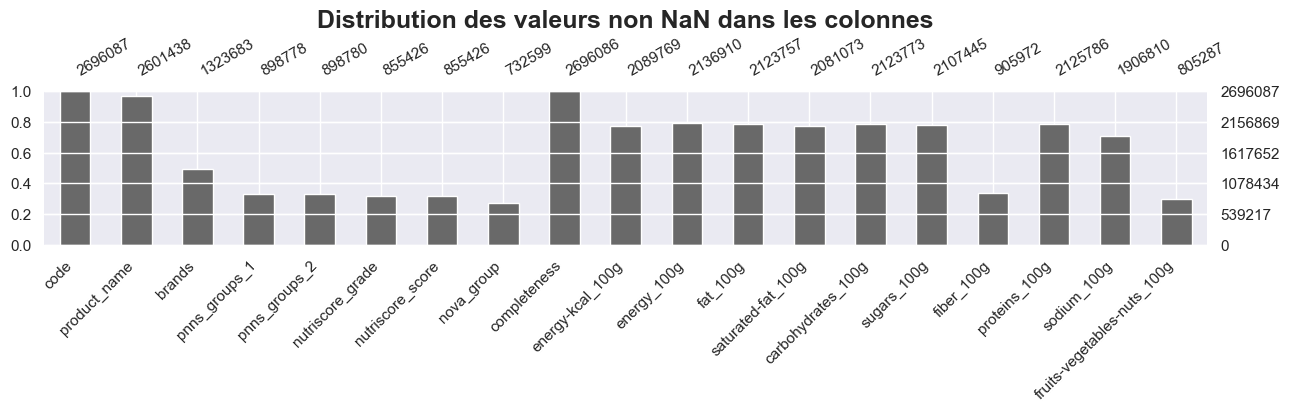

In [15]:
OFF_data = OFF_data.rename(columns = {'fruits-vegetables-nuts-estimate-from-ingredients_100g':'fruits-vegetables-nuts_100g'})
print('percentage of NaN in the dataset equal to',
      sum(OFF_data.isna().sum() / OFF_data.shape[0]*100) / OFF_data.shape[1])
msno.bar(OFF_data, figsize=(15, 2), fontsize=11)
plt.title('Distribution des valeurs non NaN dans les colonnes', fontsize=18, fontweight='bold')
plt.xticks(rotation=30)
plt.show()

## <font id='Sec.3'> 3. Rows Cleaning for Quantitative Columns

In [16]:
df_description(OFF_data.select_dtypes(include='float64'))

,nutriscore_score,nova_group,completeness,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
number null,1840661.0,1963488.0,1.0,606318.0,559177.0,572330.0,615014.0,572314.0,588642.0,1790115.0,570301.0,789277.0,1890800.0
percentage null,68.271573,72.827323,0.000037,22.488814,20.740317,21.228173,22.811356,21.227579,21.833198,66.396782,21.152915,29.274908,70.131268
count,855426.0,732599.0,2696086.0,2089769.0,2136910.0,2123757.0,2081073.0,2123773.0,2107445.0,905972.0,2125786.0,1906810.0,805287.0
mean,9.260551,3.362276,0.422077,2510920061146117284475699749185656979456.0,10273930261739200719515131115847832043520.0,51795017.497501,6.562515,28.549756,47450836.748481,108317641622057227939717680089472721485824.0,2570104242131920777548770380275191490737400117...,48.450038,8.556013
std,8.663484,1.000393,0.204159,3629794412408088737752866414107327201280000.0,15018609633091556554531570757519511669178368.0,75481457658.077606,2101.540631,105.779649,68884558146.774689,103099505774308619517357268173392645223088128.0,3747231375325309669489684318596059440709398046...,65516.305109,34.423552
min,-15.0,1.0,0.05,-53.0,-221.0,-5.0,0.0,-1.0,-17.0,-6.7,-46.0,0.0,0.0
25%,2.0,3.0,0.275,100.0,418.0,0.8,0.1,3.57,0.5,0.0,1.3,0.04,0.0
50%,10.0,4.0,0.375,259.0,1075.0,7.0,1.785714,15.7,3.533569,1.6,6.0,0.24,0.0
75%,16.0,4.0,0.5,400.0,1674.0,21.0526,7.0,53.0,17.0,3.8,12.5,0.56,0.625


### <font id='Sec.3.1'> A. Deleting products with no nutritional contents
- Checking and removing the rows with all nutritional values equal to NaN (using columns ending with 100g).

In [17]:
# Function to check and remove all rows of selected column(s) full null values
def rows_null_values(df, df_columns):
    # for multiple columns
    if np.atleast_2d(df_columns.T).shape[0] > 1:
        print('The number of rows containing only null values in the selected columns equal to',
              df[(df_columns.isnull().all(axis=1) == True)].shape[0])
        df_cleaned = df[(df_columns.notnull().any(axis=1))]
        print('After removing those rows, we are left with this number of rows:',
              df_cleaned.shape[0])
        return df_cleaned
    # for single column
    elif np.atleast_2d(df_columns.T).shape[0] == 1:
        print('The number of rows containing only null values in the selected column equal to',
              df[(df_columns.isnull())].shape[0])
        df.drop(df[(df_columns.isnull())].index, inplace=True)
        print('After removing those rows, we are left with this number of rows:', df.shape[0])
        return df
    else:
        print('please enter the column(s) name into the function')

In [18]:
OFF_data = rows_null_values(OFF_data, OFF_data[[column for column in OFF_data.columns if column.endswith('_100g')]])

The number of rows containing only null values in the selected columns equal to 436611
After removing those rows, we are left with this number of rows: 2259476


### <font id='Sec.3.2'> B. Removing rows with negative values
    Removing all rows with a negative values in one of the numerical columns (excluding the nutriscore_score column)

In [19]:
# Function that drop rows with values to exclude (outside a specific value or ceratin range)
def rows_values_to_exclude(df, df_columns,
                           greater_condition=False, greater_condition_value=0,
                           lower_condition=False, lower_condition_value=0,
                           lower_greater_condition=False, lower_greater_condition_value=0):
    
    # for multiple columns
    if np.atleast_2d(df_columns.T).shape[0] > 1:
        # checking and removing all rows with value below lower_condition_value
        if (((greater_condition == False) & (lower_condition == True) & (lower_greater_condition == False))):
            condition = df[(df_columns < lower_condition_value).any(axis=1)]
            print('The number of rows with value lower than', lower_condition_value,
                  'in one of the selected columns equal to', condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        # checking and removing all rows with value greater than greater_condition_value
        elif (((greater_condition == True) & (lower_condition == False) & (lower_greater_condition == False))):
            condition = df[(df_columns > greater_condition_value).any(axis=1)]
            print('The number of rows with value greater than', greater_condition_value,
                  'in one of the selected columns equal to', condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        # checking and removing all rows with value outside lower_greater_condition_value (l,g) range
        elif (((greater_condition == False) & (lower_condition == False) & (lower_greater_condition == True))):
            condition = df[((df_columns > lower_greater_condition_value[1])
                            | (df_columns < lower_greater_condition_value[0])).any(axis=1)]
            print('The number of rows with value greater than', lower_greater_condition_value[1],
                  'and lower than', lower_greater_condition_value[0],
                  'in one of the selected columns equal to', condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        else:
            print('Please activate only one condition.')
    
    # for single column
    elif np.atleast_2d(df_columns.T).shape[0] == 1:
        # checking and removing all rows with value below lower_condition_value
        if (((greater_condition == False) & (lower_condition == True) & (lower_greater_condition == False))):
            condition = df[(df_columns < lower_condition_value)]
            print('The number of rows with value lower than a selected value in the selected column equal to',
                  condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        # checking and removing all rows with value greater than greater_condition_value
        elif (((greater_condition == True) & (lower_condition == False) & (lower_greater_condition == False))):
            condition = df[(df_columns > greater_condition_value)]
            print('The number of rows with value greater than a selected value in the selected column equal to',
                  condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        # checking and removing all rows with value outside lower_greater_condition_value (l,g) range
        elif (((greater_condition == False) & (lower_condition == False) & (lower_greater_condition == True))):
            condition = df[((df_columns > lower_greater_condition_value[1])
                            | (df_columns < lower_greater_condition_value[0]))]
            print('The number of rows with value not a selected range in the selected column equal to',
                  condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        else:
            print('Please activate only one condition.')

In [20]:
rows_values_to_exclude(OFF_data,
                       OFF_data[[column for column in OFF_data.select_dtypes(include='float64').columns if ((column != 'nutriscore_score'))]],
                       lower_condition=True,
                       lower_condition_value=0)

The number of rows with value lower than 0 in one of the selected columns equal to 41
After removing those rows, we are left with this number of rows: 2259435


### <font id='Sec.3.3'> C. Removing rows with wrong nutritional values

- Removing all lines having at least one numerical value bigger than 100 g (or 100 %) in all columns ending with 100g (excluding the energy-kcal_100g, and energy_100g columns.

In [21]:
rows_values_to_exclude(OFF_data,
                       OFF_data[[column for column in OFF_data.columns if ((column.endswith('_100g'))
                                                                           & (column != 'energy-kcal_100g')
                                                                           & (column != 'energy_100g'))]],
                       greater_condition=True,
                       greater_condition_value=100)

The number of rows with value greater than 100 in one of the selected columns equal to 3051
After removing those rows, we are left with this number of rows: 2256384


- Removing all lines with sum of all values in fat_100g, carbohydrates_100g, proteins_100g and sodium_100g columns greater than 100.

In [22]:
# Function that drop rows with sum value to exclude (outside a specific value or ceratin range);
def rows_sum_values_to_exclude(df, df_columns,
                               greater_condition=False, greater_condition_value=0,
                               lower_condition=False, lower_condition_value=0,
                               lower_greater_condition=False, lower_greater_condition_value=0):
    
    # Check for at least two column selected, otherwise there is no need to use the sum of that function
    if np.atleast_2d(df_columns.T).shape[0] > 1:
        # Checking and removing all rows with sum value below lower_condition_value
        if (((greater_condition == False) & (lower_condition == True) & (lower_greater_condition == False))):
            condition = df[(df_columns.sum(axis=1) < lower_condition_value)]
            print('The number of rows with sum value lower than the selected value in the selected columns equal to',
                  condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        # Checking and removing all rows with sum value greater than greater_condition_value
        elif (((greater_condition == True) & (lower_condition == False) & (lower_greater_condition == False))):
            condition = df[(df_columns.sum(axis=1) > greater_condition_value)]
            print('The number of rows with sum value greater than the selected value in the selected columns equal to',
                  condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        # Checking and removing all rows with sum value outside lower_greater_condition_value (l,g) range
        elif (((greater_condition == False) & (lower_condition == False) & (lower_greater_condition == True))):
            condition = df[((df_columns.sum(axis=1) > lower_greater_condition_value[1])
                            | (df_columns.sum(axis=1) < lower_greater_condition_value[0]))]
            print('The number of rows with sum value not in the selected range in the selected columns equal to',
                  condition.shape[0])
            df.drop(condition.index, inplace=True)
            print('After removing those rows, we are left with this number of rows:', df.shape[0])
        else:
            print('Please activate only one condition.')
    else:
        print('Please select at least two columns to perform sum.')

In [23]:
rows_sum_values_to_exclude(OFF_data,
                           OFF_data[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'sodium_100g']],
                           greater_condition=True,
                           greater_condition_value=100)

The number of rows with sum value greater than the selected value in the selected columns equal to 20985
After removing those rows, we are left with this number of rows: 2235399


- Checking if 'saturated-fat_100g' greater than 'fat_100g', or if the sum of 'sugars_100g', and 'fiber_100g' greater than 'carbohydrates_100g'. If so, we remove those lines.

In [24]:
rows_values_to_exclude(OFF_data,
                       OFF_data['saturated-fat_100g'],
                       greater_condition=True,
                       greater_condition_value=OFF_data['fat_100g'])

The number of rows with value greater than a selected value in the selected column equal to 1487
After removing those rows, we are left with this number of rows: 2233912


In [25]:
rows_sum_values_to_exclude(OFF_data,
                           OFF_data[['sugars_100g', 'fiber_100g']],
                           greater_condition=True,
                           greater_condition_value=OFF_data['carbohydrates_100g'])

The number of rows with sum value greater than the selected value in the selected columns equal to 111416
After removing those rows, we are left with this number of rows: 2122496


### <font id='Sec.3.4'> D. Removing rows with wrong energy values
- Fat is the most energy dense, at 9 Kcal/gram. Thus 100 g give 900 Kcal. The maximum value cannot be greater than 900. Removing all lines having a value greater than 900 in column energy-Kcal_100g.

In [26]:
rows_values_to_exclude(OFF_data,
                       OFF_data['energy-kcal_100g'],
                       greater_condition=True,
                       greater_condition_value=900)

The number of rows with value greater than a selected value in the selected column equal to 5627
After removing those rows, we are left with this number of rows: 2116869


- Kcal and KJ are the two common energy units used in the world for food label. 1 Kcal is 4.184 KJ thus the maximum value for an energy unit which is 900 Kcal/g equal 3765.6 KJ. Removing all lines having a value greater than 3765.6 in column energy_100g.

In [27]:
rows_values_to_exclude(OFF_data,
                       OFF_data['energy_100g'],
                       greater_condition=True,
                       greater_condition_value=3765.6)

The number of rows with value greater than a selected value in the selected column equal to 7087
After removing those rows, we are left with this number of rows: 2109782


- Comparing the contents of those two columns for null and 0 values.

In [28]:
display((OFF_data[['energy-kcal_100g', 'energy_100g']].notna()
         & OFF_data[['energy-kcal_100g','energy_100g']] != 0).groupby(['energy-kcal_100g', 'energy_100g']).size())

energy-kcal_100g  energy_100g
False             False           175536
                  True             41042
True              False              378
                  True           1892826
dtype: int64

    - For the rows where both columns are not filled, we are going to estimate the value of energy-kcal_100g from the carbohydrate, fat, and protein contents (each 1g of carbohydrate or protein correspond to 4 Kcal and each 1g of fat correspond to 9 Kcal).

In [29]:
comp = ((OFF_data[['energy_100g', 'energy-kcal_100g']] == 0)
        | (OFF_data[['energy_100g', 'energy-kcal_100g']].isna())).sum(axis=1)
index_check = OFF_data.index[(comp == 2)]
OFF_data.loc[OFF_data.index[(comp == 2)], ['energy-kcal_100g']] = (OFF_data['fat_100g']*9
                                                                   + OFF_data['carbohydrates_100g']*4
                                                                   + OFF_data['proteins_100g']*4)
OFF_data.loc[OFF_data.index[(comp == 2)], ['energy_100g']] = (OFF_data['fat_100g']*9
                                                              + OFF_data['carbohydrates_100g']*4
                                                              + OFF_data['proteins_100g']*4)*4.184

    - For the rows where only energy_100g filled, we are going to fill energy-kcal_100g column with the value of energy_100g/4.184.
    - For the rows where only energy-kcal_100g filled, we are going to fill energy_100g column with the value of energy-kcal_100g*4.184.

In [30]:
index_check = OFF_data.index[(comp == 1)
                             & (OFF_data['energy-kcal_100g'].isna()
                                | OFF_data['energy-kcal_100g'] == 0)]
OFF_data.loc[OFF_data.index[(comp == 1)], ['energy-kcal_100g']] = (OFF_data['energy_100g']/4.184)
index_check = OFF_data.index[(comp == 1)
                             & (OFF_data['energy_100g'].isna()
                                | OFF_data['energy_100g'] == 0)]
OFF_data.loc[OFF_data.index[(comp == 1)], ['energy_100g']] = (OFF_data['energy-kcal_100g']*4.184)

- Now we can check the correlation between the two energy columns. Keep in  mind that 1KJ = 4.184Kcal.

count    1.949074e+06
mean     4.262782e+00
std      3.042163e+01
min      1.921968e-04
25%      4.183051e+00
50%      4.184000e+00
75%      4.185000e+00
max      3.810000e+04
dtype: float64


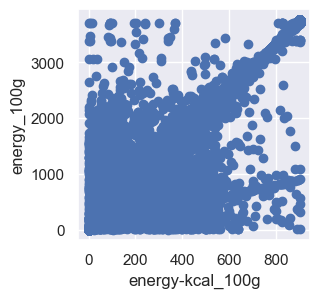

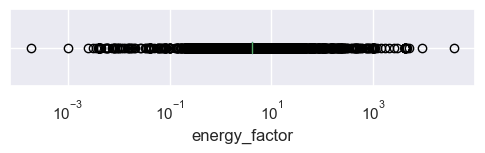

In [31]:
print((OFF_data['energy_100g'] / OFF_data['energy-kcal_100g']).describe())
plt.figure(figsize=(3, 3))
plt.plot(OFF_data['energy-kcal_100g'], OFF_data['energy_100g'], 'o')
plt.xlabel('energy-kcal_100g')
plt.ylabel('energy_100g')
plt.show()
plt.figure(figsize=(6, 1))
(OFF_data['energy_100g'] / OFF_data['energy-kcal_100g']).plot.box(vert=False)
plt.semilogx()
plt.xlabel('energy_factor')
plt.show()

    The diagonal line in the scatter plot means that the two columns are correlated, outside that diagonal line are outliers. We can see from the describe informations that most values are very close to the 4.184 value.

    - Let's drop the outliers (input error) by accepting maximum 5% error on that value, i.e.  4.184 +-5%. (the 5% value chosen to not loose much data).

In [32]:
condition = OFF_data[((OFF_data['energy_100g'] / OFF_data['energy-kcal_100g'] > (4.184*1.05))
                      | (OFF_data['energy_100g'] / OFF_data['energy-kcal_100g'] < (4.184*0.95)))]
print('The number of lines with wrong energy factor equal to', condition.shape[0])
OFF_data.drop(condition.index, inplace=True)
print('After removing those rows, we are left with this number of rows:', OFF_data.shape[0])
print((OFF_data['energy_100g'] / OFF_data['energy-kcal_100g']).describe())

The number of lines with wrong energy factor equal to 10888
After removing those rows, we are left with this number of rows: 2098894
count    1.938186e+06
mean     4.182964e+00
std      2.270373e-02
min      3.975000e+00
25%      4.183060e+00
50%      4.184000e+00
75%      4.185000e+00
max      4.393162e+00
dtype: float64


- We drop the energy_100g column from our dataset and keep energy-kcal_100g column.

In [33]:
OFF_data.drop(['energy_100g'], axis=1, inplace=True)

- Checking the energy value using carbohydrate, fat and protein contents.

    Each 1g of carbohydrate or protein correspond to 4 Kcal and each 1g of fat correspond to 9 Kcal. We are going to calcultate the energy from the carbohydrate, fat, and protein contents and then compare it with the value in 'energy-kcal_100g' column.

count    1.916855e+06
mean              inf
std               NaN
min      0.000000e+00
25%      9.728972e-01
50%      9.943343e-01
75%      1.006897e+00
max               inf
dtype: float64


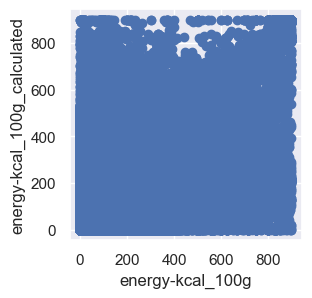

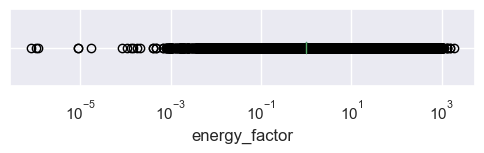

In [34]:
print(((OFF_data['fat_100g']*9 + OFF_data['carbohydrates_100g']*4 + OFF_data['proteins_100g']*4) / OFF_data['energy-kcal_100g']).describe())
plt.figure(figsize=(3, 3))
plt.plot(OFF_data['energy-kcal_100g'], (OFF_data['fat_100g']*9
                                        + OFF_data['carbohydrates_100g']*4
                                        + OFF_data['proteins_100g']*4), 'o')
plt.xlabel('energy-kcal_100g')
plt.ylabel('energy-kcal_100g_calculated')
plt.show()
plt.figure(figsize=(6, 1))
((OFF_data['fat_100g']*9 + OFF_data['carbohydrates_100g']*4 + OFF_data['proteins_100g']*4) / OFF_data['energy-kcal_100g']).plot.box(vert=False)
plt.semilogx()
plt.xlabel('energy_factor')
plt.show()

    We see that lot of values deviate from the diagonal line of correlation. To not loose lot of data, I will use the [(Q1-5*IQR),(Q3+5*IQR)] method to remove those outliers.

In [35]:
# Function that remove outlier from energy via using carbs, fat and protein content to estimate the energy and compared ro the energy column
def energy_outliers(df, factor_IQR):
    calculated_energy = (df['fat_100g']*9 + df['carbohydrates_100g']*4 + df['proteins_100g']*4)
    energy_factor = (calculated_energy / df['energy-kcal_100g'])
    Q1, Q3 = energy_factor.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    condition = df[((calculated_energy < ((Q1-factor_IQR*IQR)*OFF_data['energy-kcal_100g']))
                    | (calculated_energy > ((Q3+factor_IQR*IQR)*OFF_data['energy-kcal_100g'])))
                  ]
    print('The number of lines with wrong energy factor equal to', condition.shape[0])
    df.drop(condition.index, inplace=True)
    print('After removing those rows, we are left with this number of rows:', df.shape[0])

In [36]:
energy_outliers(OFF_data, 5)

The number of lines with wrong energy factor equal to 183237
After removing those rows, we are left with this number of rows: 1915657


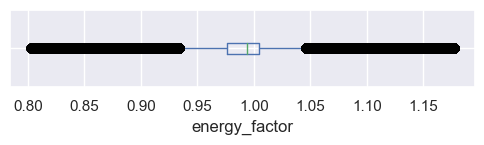

In [37]:
plt.figure(figsize=(6, 1))
((OFF_data['fat_100g']*9 + OFF_data['carbohydrates_100g']*4 + OFF_data['proteins_100g']*4) / OFF_data['energy-kcal_100g']).plot.box(vert=False)
plt.xlabel('energy_factor')
plt.show()

### <font id='Sec.3.5'> E. Removing rows with wrong nutri and Nova score
- Nutrition score range between -15 to 40, checking and removing the rows outside that range. Nova_group score range between 1 and 4, checking and removing the rows outside that range as well.

In [38]:
rows_values_to_exclude(OFF_data, OFF_data['nutriscore_score'],
                       lower_greater_condition=True,
                       lower_greater_condition_value=(-15, 40))

The number of rows with value not a selected range in the selected column equal to 0
After removing those rows, we are left with this number of rows: 1915657


In [39]:
rows_values_to_exclude(OFF_data, OFF_data['nova_group'],
                       lower_greater_condition=True,
                       lower_greater_condition_value=(1, 4))

The number of rows with value not a selected range in the selected column equal to 0
After removing those rows, we are left with this number of rows: 1915657


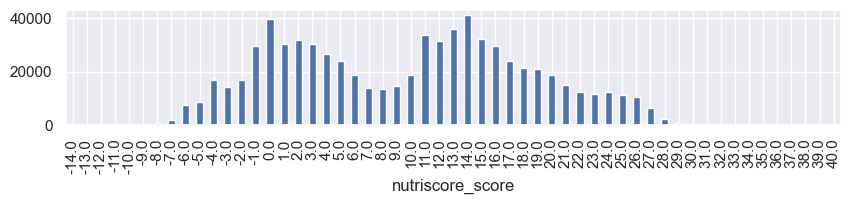

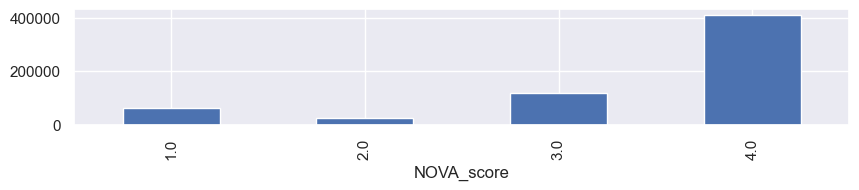

In [40]:
plt.figure(figsize=(10, 1.5))
OFF_data['nutriscore_score'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('nutriscore_score')
plt.show()
plt.figure(figsize=(10, 1.5))
OFF_data['nova_group'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('NOVA_score')
plt.show()

    The distribution of nutriscore seems fine, no over-representation of values. Nova-score has a high representation score at 4 which might be due to highly processed food representation in the dataset.

### <font id='Sec.3.6'> F. Final check on all numerical columns

In [41]:
df_description(OFF_data.select_dtypes(include='float64'))

,nutriscore_score,nova_group,completeness,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
number null,1184135.0,1297910.0,0.0,123061.0,134517.0,165981.0,134997.0,146086.0,1203658.0,132547.0,301809.0,1222991.0
percentage null,61.813519,67.752734,0.0,6.423958,7.021977,8.664443,7.047034,7.625895,62.832647,6.919141,15.754856,63.841857
count,731522.0,617747.0,1915657.0,1792596.0,1781140.0,1749676.0,1780660.0,1769571.0,711999.0,1783110.0,1613848.0,692666.0
mean,9.650333,3.416185,0.457637,279.562019,13.83367,5.149943,29.500239,13.221357,2.741871,9.131152,0.536891,7.091722
std,8.605996,0.97229,0.194906,179.915664,16.839851,7.569441,27.977092,19.372612,4.068529,10.064642,1.838611,19.859932
min,-14.0,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.0,3.0,0.275,120.0,1.2,0.14,4.132231,0.7,0.0,2.0,0.04,0.0
50%,11.0,4.0,0.3875,277.0,7.9,2.0,18.0,3.6,1.5,6.5,0.257143,0.0
75%,16.0,4.0,0.5,400.0,21.6,7.3,54.4,18.421053,3.6,13.0,0.571,0.0


All numerical columns seem fine. The null value treatment will be done in section 6.

## <font id='Sec.4'> 4. Rows Cleaning for Qualitative Columns

In [42]:
df_description(OFF_data.select_dtypes(exclude='float64'))

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutriscore_grade
type,object,object,object,object,object,object
number null,0.0,13558.0,927270.0,1198305.0,1198304.0,1184135.0
percentage null,0.0,0.707747,48.404803,62.553213,62.553161,61.813519
count,1915657,1902099,988387,717352,717353,731522
unique,1915629,1235029,169464,11,40,5
top,8437006177665,Comté,Carrefour,Sugary snacks,Biscuits and cakes,d
freq,2,927,13219,150834,66170,240654


### <font id='Sec.4.1'> A. Cleaning barcode and product_name
- Checking the number of lines with null, or 1 characters value on the product_name. Dropping those lines if any.

In [43]:
OFF_data = rows_null_values(OFF_data, OFF_data['product_name'])
print('The number of rows containing 0 or 1 caracters values in the product_name equal to',
      OFF_data.loc[OFF_data[OFF_data['product_name'].str.len() < 2].index, 'product_name'].shape[0])
OFF_data.drop(OFF_data[(OFF_data['product_name'].str.len() < 2)].index, inplace=True)
print('After removing those rows, we are left with this number of rows:', OFF_data.shape[0])

The number of rows containing only null values in the selected column equal to 13558
After removing those rows, we are left with this number of rows: 1902099
The number of rows containing 0 or 1 caracters values in the product_name equal to 186
After removing those rows, we are left with this number of rows: 1901913


- Checking barcode validity (EAN-13, EAN-8 and UPC (12-digit) format) using stdnum library and removing the product with invalid barcode.

In [44]:
OFF_data.insert(1,'code_val', OFF_data['code'].apply(is_valid))
print('nb of invalid codes:', (~OFF_data['code_val']).sum())
print('pctage of valid codes: {:.2f}%'.format(OFF_data['code_val'].sum()*100/OFF_data.shape[0]))
OFF_data.drop(OFF_data[(OFF_data['code_val'] == False)].index, inplace=True)
print('After removing the invalid code, we are left with this number of rows:', OFF_data.shape[0])

nb of invalid codes:  53676
pctage of valid codes: 97.18%
After removing the invalid code, we are left with this number of rows: 1848237


- We drop the code_val we created from our dataset.

In [45]:
OFF_data.drop(['code_val'], axis=1, inplace=True)

### <font id='Sec.4.2'> B. Duplicate treatment
- Checking and removing duplicated rows on the product_name and brands columns by keeping the row with the highest completeness score.

In [46]:
# Function that remove duplicated rows on selected columns.
def removing_duplicates(df, df_columns):
    print('The number of duplicated rows on selected columns equal to',
          df.loc[df[df_columns].duplicated(keep=False), :].shape[0])
    df.drop_duplicates(subset=df_columns, inplace=True, ignore_index=True)
    print('After removing those rows, we are left with this number of rows:', df.shape[0])
    return df

In [47]:
OFF_data = OFF_data.sort_values('completeness',ascending=False)
OFF_data = removing_duplicates(OFF_data, ['product_name', 'brands'])

The number of duplicated rows on selected columns equal to 474648
After removing those rows, we are left with this number of rows: 1488858


- We drop the completness column since it kept only to serve the duplicate cleaning.

In [48]:
OFF_data.drop(['completeness'], axis = 1, inplace=True)

### <font id='Sec.4.3'> C. Removing rows with wrong nutriscore grade
    Checking and removing all lines having nutriscore_grade not in the range between a to e and not having null value.

In [49]:
valid_nutriscore_grade = ['a', 'b', 'c', 'd', 'e']
condition = OFF_data[((OFF_data['nutriscore_grade'].isin(valid_nutriscore_grade))
                      | (OFF_data['nutriscore_grade'].isnull()))
                     == False]
print('The number of lines with wrong nutriscore grade equal to', condition.shape[0])
OFF_data.drop(condition.index, inplace=True)
print('After removing those rows, we are left with this number of rows:', OFF_data.shape[0])

The number of lines with wrong nutriscore grade equal to 0
After removing those rows, we are left with this number of rows: 1488858


## <font id='Sec.5'> 5. Treating missing values

In [50]:
df_description(OFF_data.select_dtypes(include='float64'))

,nutriscore_score,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
number null,880950.0,955579.0,94260.0,104150.0,127295.0,104212.0,111763.0,910529.0,102162.0,226088.0,886823.0
percentage null,59.169511,64.182011,6.331027,6.995294,8.549842,6.999459,7.506626,61.156202,6.861769,15.18533,59.563975
count,607908.0,533279.0,1394598.0,1384708.0,1361563.0,1384646.0,1377095.0,578329.0,1386696.0,1262770.0,602035.0
mean,9.625812,3.433565,279.2281,13.520427,5.026441,30.517896,13.693081,2.782783,8.710806,0.530765,7.099256
std,8.630228,0.955663,178.891664,16.412985,7.416056,27.921037,19.506182,4.068604,9.782634,1.880925,19.67419
min,-14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.0,3.0,120.0,1.2,0.1,4.9,0.833333,0.0,2.0,0.04,0.0
50%,11.0,4.0,278.0,7.7,2.0,20.0,4.0,1.6,6.25,0.243,0.0
75%,16.0,4.0,400.0,21.05,7.14,55.4,20.0,3.6,12.0,0.56,0.0


### <font id='Sec.5.1'> A. Treating missing values in quantitative columns

- First we are going to plot the correlation map between the columns.
    - For the columns correlated with each other, I'm going to use IterativeImputer.
    - For the column that are not correlated with each other, I'm going to use the median of the distribution for each product depending of its product category (pnns_group_2).
    - For the classification columns like nova-score or nutriscore, I'm going to use Knn or RandomForest classifier.

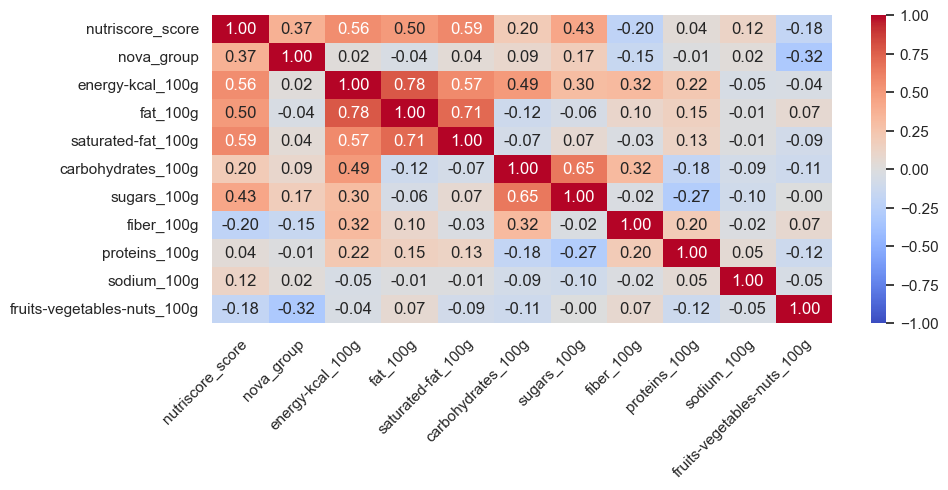

In [51]:
OFF_data = OFF_data.rename(columns = {'fruits-vegetables-nuts-estimate-from-ingredients_100g':'fruits-vegetables-nuts_100g'})
plt.figure(figsize = (10, 4))
sns.heatmap(OFF_data.select_dtypes(include='float64').corr(method='pearson'),
            vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='0.2f')
plt.xticks(ha='right', rotation=45, rotation_mode='anchor')
plt.show()

    From the heatmap, we can see that nova_group, fiber, protein, sodium, and fruits-vegetable-nuts columns are not much correlated to the other columns. We are left with 'nutriscore_score', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', and 'sugars_100g' columns.

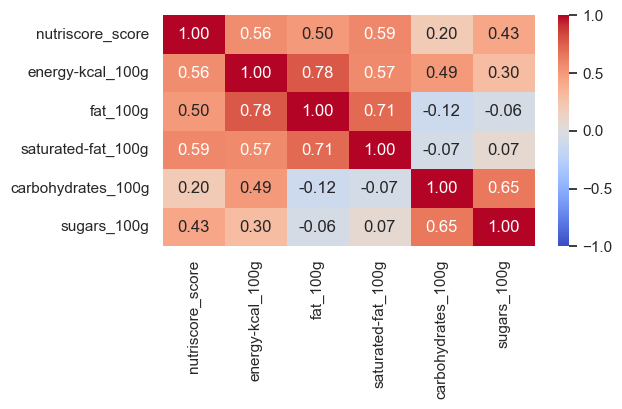

In [52]:
column = ['nutriscore_score', 'energy-kcal_100g', 'fat_100g',
          'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g']
plt.figure(figsize = (6, 3))
sns.heatmap(OFF_data[column].corr(method='pearson'), vmin=-1,
            vmax=1, annot=True, cmap='coolwarm', fmt='0.2f')
plt.show()

    Final obseravtions:
    - We see that we can use IterativeImputer on fat and sat_fat column together, then on carbs and sugars together.
    - For the products with known pnns_group_2, we are going to fill the missing values in protein, fiber, sodium, and fruit-vegetables-nuts columns with the median value according to the product category using pnns_group_2. Then for those with unknown pnns_group_2, we are going to fill the missing value in those columns with the median of all the data.
    - Then, I'm going to calculate the missing values of energy using the now complete fat, carbs, and protein columns.
    - After, I'm going to treat the error generated due to the null filling on the nutritional values.
    - Then, I'm going to use classifiers to retreive nutriscore_score, and nova_group from all columns ending with 100g.
    - Finally, I'm going to check for wrong nutri-score and nova_group.
- Iterative Imputer on fat and sat_fat columns, and on carbs and sugars columns

In [53]:
def iterative_imputer(df, df_columns):
    imputer = IterativeImputer(missing_values=np.nan, initial_strategy='median')
    imputer.fit(df[df_columns])
    df[df_columns] = imputer.transform(df[df_columns])

In [54]:
iterative_imputer(OFF_data, ['fat_100g', 'saturated-fat_100g'])
iterative_imputer(OFF_data, ['carbohydrates_100g', 'sugars_100g'])

- Filling the null values in fiber, proteins, sodium, fruits-vegetables-nuts columns according to pnns_group_2 median

In [55]:
for col in ['fiber_100g', 'proteins_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']:
    OFF_data[col].fillna(OFF_data.groupby('pnns_groups_2')[col].transform('median'), inplace=True)

# Median filling of the left over null value in fiber, proteins, sodium, fruits-vegetables-nuts columns
for col in ['fiber_100g', 'proteins_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g']:
    OFF_data[col].fillna(OFF_data[col].median(), inplace=True)

- Cleaning columns 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', and 'fruits-vegetables-nuts_100g'.

In [56]:
# Replacing negative values from all columns except nutriscore by 0
OFF_data[[column for column in OFF_data.select_dtypes(include='float64').columns if ((column != 'nutriscore_score'))]] = OFF_data[[column for column in OFF_data.select_dtypes(include='float64').columns if ((column != 'nutriscore_score'))]].mask(OFF_data[[column for column in OFF_data.select_dtypes(include='float64').columns if ((column != 'nutriscore_score'))]] < 0, 0)
# Replacing values greater than 100 from all columns ending with 100g except the energy column by 100
OFF_data[[column for column in OFF_data.select_dtypes(include='float64').columns if ((column.endswith('_100g')) & (column != 'energy-kcal_100g'))]] = OFF_data[[column for column in OFF_data.select_dtypes(include='float64').columns if ((column.endswith('_100g')) & (column != 'energy-kcal_100g'))]].mask(OFF_data[[column for column in OFF_data.select_dtypes(include='float64').columns if ((column.endswith('_100g')) & (column != 'energy-kcal_100g'))]] > 100, 100)
# Removing values sum on fat, carbs, protein, and sodium greater than 100
rows_sum_values_to_exclude(OFF_data, OFF_data[['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'sodium_100g']], greater_condition=True, greater_condition_value=100)
# Replacing values on sat_fat with the value of fat when sat_fat is greater than the value in fat column
OFF_data['saturated-fat_100g'] = OFF_data['saturated-fat_100g'].mask(OFF_data['saturated-fat_100g'] > OFF_data['fat_100g'], OFF_data['fat_100g'])
# Replacing value on sugar greater than carbs with the value on carbs
OFF_data['sugars_100g'] = OFF_data['sugars_100g'].mask(OFF_data['sugars_100g'] > OFF_data['carbohydrates_100g'], OFF_data['carbohydrates_100g'])
# When the sum on sugar and fiber greater than the value in carbs column, we replace the value of fiber with the difference between carbs and sugar.
OFF_data['fiber_100g'] = OFF_data['fiber_100g'].mask((OFF_data['fiber_100g'] + OFF_data['sugars_100g']) > OFF_data['carbohydrates_100g'], (OFF_data['carbohydrates_100g'] - OFF_data['sugars_100g']))

The number of rows with sum value greater than the selected value in the selected columns equal to 2211
After removing those rows, we are left with this number of rows: 1486647


- Calculating the missing energy value using fat, carbs and protein contents.

In [57]:
# Calculating the missing energy value using fat, carbs and protein contents
OFF_data['energy-kcal_100g'].fillna((4*OFF_data['carbohydrates_100g']
                                     + 4*OFF_data['proteins_100g']
                                     + 9*OFF_data['fat_100g']), inplace=True)

- Cleaning the energy column:

In [58]:
# Removing rows with energy value greater than 900 Kcal
rows_values_to_exclude(OFF_data, OFF_data['energy-kcal_100g'], greater_condition=True, greater_condition_value=900)

The number of rows with value greater than a selected value in the selected column equal to 0
After removing those rows, we are left with this number of rows: 1486647


- Using classifier to retrieve nutriscore_score and nova_group.

    we start with normalizing the columns that will be used to retrieve nutriscore_score, nutriscore_grade and nova_group. Those are all columns ending with 100g.

In [59]:
# Let's start with resetting the index of our database
OFF_data = OFF_data.reset_index(drop=True)
# Creating a database where 'nutriscore_score' and the other columns ending with 100g is not null
columns_list = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                           & (column != 'fruits-vegetables-nuts_100g'))
                                                          | (column == 'nutriscore_score'))]
columns_list_data = [column for column in OFF_data.columns if ((column.endswith('_100g'))
                                                               & (column != 'fruits-vegetables-nuts_100g'))]
columns_list_target = 'nutriscore_score'
data = OFF_data[(OFF_data[columns_list].notna()).all(axis=1)].reset_index(drop=True)
# Selecting 100% of that selected database
sample_index = np.random.randint(data.shape[0], size=int(data.shape[0]*1))
sample_data = data[columns_list_data].iloc[sample_index].reset_index(drop=True)
# Normalize the sample_data for the knn
sample_data = pd.DataFrame(RobustScaler().fit_transform(sample_data))
sample_data.columns = columns_list_data
sample_target = data[columns_list_target].iloc[sample_index].reset_index(drop=True)
# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(sample_data, sample_target, train_size=0.8)

    we train and test first the KNN classifier on multiple k neighbors to find the best value.

In [60]:
# Function that fit and calcultae error rate for different k_neighbors. It genrate a plot for the different k_neighbors
def knn_score(xtrain, ytrain, xtest, ytest, k_range):
    error_uniform = []
    error_distance = []

    for k in k_range:
        classifier = neighbors.KNeighborsClassifier(k, weights='uniform', n_jobs=-1)#, weights = 'distance')
        classifier.fit(xtrain, ytrain)
        error_uniform.append(100*(1 - classifier.score(xtest, ytest)))
    
        classifier = neighbors.KNeighborsClassifier(k, weights='distance', n_jobs=-1)
        classifier.fit(xtrain, ytrain)
        error_distance.append(100*(1 - classifier.score(xtest, ytest)))
    
    plt.figure(figsize = (10, 5))
    # Plot the error rates.
    # The models with uniform weights are plotted with a solid blue line.
    # The models with distance weights are plotted with a dashed green line.
    # The circular markers mark the distinct K-values.
    plt.plot(k_range, error_uniform, c='green', linestyle='solid', 
             marker='o', markerfacecolor='green',  label='Error uniform')
    plt.plot(k_range, error_distance, c='blue', linestyle='dashed', 
             marker='o', markerfacecolor='blue', label='Error distance')

    plt.legend()
    
    plt.xlabel('K-value')
    plt.ylabel('Error rate')
    plt.show()

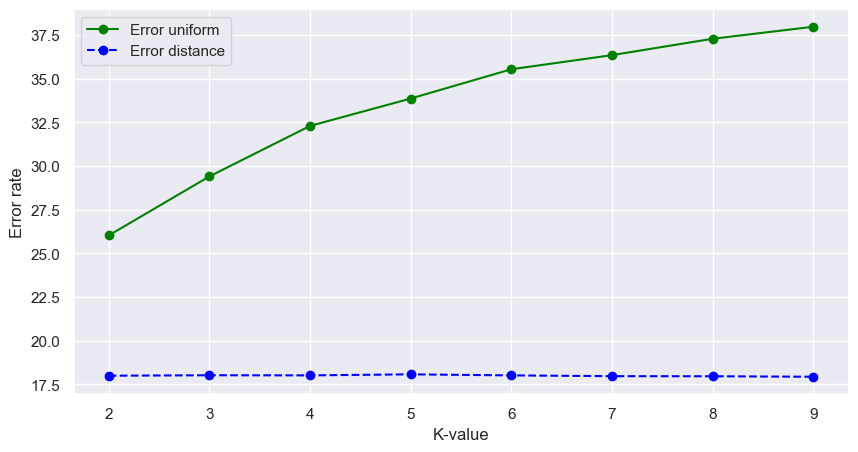

In [61]:
knn_score(xtrain, ytrain, xtest, ytest, range(2, 10))

    It seems that distance weight perform better than uniform weight for KNeighborsClassifier. However, the error rate is not low enough. We will try the RandomForestClassifier to see if it can give better score.

In [62]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain, ytrain)
print('Error using RandomForestClassifier equal to', (1 - classifier.score(xtest, ytest)))

Error using RandomForestClassifier equal to 0.12705632690662627


    We see that RandomForestClassifier give better error rate than KNeighborsClassifier. We will proceed and use RandomForestClassifier to retrieve nutriscore.
    - We first generate a database with only null value in nutriscore and predict the nutriscore using the RandomForestClassifier fit model.

In [63]:
# We create a database where only null in nutriscrore, and no null value on all columns ending with 100g
data_null = OFF_data[((OFF_data[columns_list_data].notna()).all(axis=1)) & (OFF_data[columns_list_target].isna())]
data_null = data_null[columns_list_data]
data_null_index = data_null.index
data_null = pd.DataFrame(RobustScaler().fit_transform(data_null[columns_list_data])).set_index(data_null_index)
data_null.columns = columns_list_data
# We predict the value of nutriscrore from all column ending with 100g using the model
data_null[columns_list_target] = classifier.predict(data_null)
# We add those values to the main database
OFF_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]
# Cleaning the new nutriscore values from values outside (-15, 40) range.
rows_values_to_exclude(OFF_data, OFF_data['nutriscore_score'],
                       lower_greater_condition=True,
                       lower_greater_condition_value=(-15, 40))

C:\Users\DJANGO\AppData\Local\Temp\ipykernel_7552\3738398494.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openfoodfacts_products_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]


The number of rows with value not a selected range in the selected column equal to 0
After removing those rows, we are left with this number of rows: 1486647


- Using classifier to retrieve nova_group.

    We redo the same process as on nutri-score. We will add the nutri-score this time to the fitting along all the 100g columns.

In [64]:
# Creating a database where 'nova_group', nutriscore and the other columns ending with 100g is not null
columns_list = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                           & (column != 'fruits-vegetables-nuts_100g'))
                                                          | (column == 'nutriscore_score')
                                                          | (column == 'nova_group'))]
columns_list_data = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                                & (column != 'fruits-vegetables-nuts_100g'))
                                                               | (column == 'nutriscore_score'))]
columns_list_target = 'nova_group'
data = OFF_data[(OFF_data[columns_list].notna()).all(axis=1)].reset_index(drop=True)
# Selecting 100% of that selected database
sample_index = np.random.randint(data.shape[0], size=int(data.shape[0]*1))
sample_data = data[columns_list_data].iloc[sample_index].reset_index(drop=True)
# Normalize the sample_data for the knn
sample_data = pd.DataFrame(RobustScaler().fit_transform(sample_data))
sample_data.columns = columns_list_data
sample_target = data[columns_list_target].iloc[sample_index].reset_index(drop=True)
# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(sample_data, sample_target, train_size=0.8)

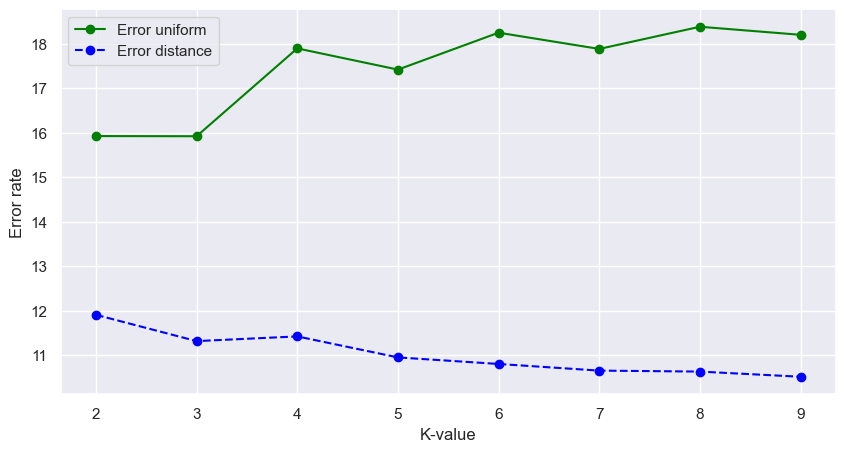

In [65]:
knn_score(xtrain, ytrain, xtest, ytest, range(2, 10))

In [66]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain, ytrain)
print('Error using RandomForestClassifier equal to', (1 - classifier.score(xtest, ytest)))

Error using RandomForestClassifier equal to 0.09504589911580841


    We see that RandomForestClassifier is still giving better score. We will apply the RandomForestClassifier fit model to retrieve Nova_group.

In [67]:
# We create a database where only null in nova_group, and no null value on all columns ending with 100g and nutriscore
data_null = OFF_data[((OFF_data[columns_list_data].notna()).all(axis=1)) & (OFF_data[columns_list_target].isna())]
data_null = data_null[columns_list_data]
data_null_index = data_null.index
data_null = pd.DataFrame(RobustScaler().fit_transform(data_null[columns_list_data])).set_index(data_null_index)
data_null.columns = columns_list_data
# We predict the value of nutriscrore from all column ending with 100g using the model
data_null[columns_list_target] = classifier.predict(data_null[columns_list_data])
# We add those values to the main database
OFF_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]
# Cleaning the new nova_group score from values outside (1, 4) range.
rows_values_to_exclude(OFF_data, OFF_data['nova_group'],
                       lower_greater_condition=True, lower_greater_condition_value=(1, 4))

C:\Users\DJANGO\AppData\Local\Temp\ipykernel_7552\2932231301.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openfoodfacts_products_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]


The number of rows with value not a selected range in the selected column equal to 0
After removing those rows, we are left with this number of rows: 1486647


In [68]:
df_description(OFF_data.select_dtypes(include='float64'))

,nutriscore_score,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
type,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
number null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
percentage null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count,1486647.0,1486647.0,1486647.0,1486647.0,1486647.0,1486647.0,1486647.0,1486647.0,1486647.0,1486647.0,1486647.0
mean,9.990958,3.655283,276.650222,13.391516,4.924982,30.34248,13.554965,1.574076,8.48334,0.483917,3.265502
std,8.666456,0.815177,173.545764,15.784141,7.115724,26.935841,18.770483,2.769936,9.496268,1.730145,13.633073
min,-14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.0,4.0,129.0,1.5,0.2,5.6,1.0,0.0,2.0,0.044,0.0
50%,11.0,4.0,266.515425,8.7,2.2,23.333333,4.7,1.0,6.15,0.24,0.0
75%,16.0,4.0,394.0,20.0,6.5,53.57,17.8,1.5,11.6,0.48,0.0


### <font id='Sec.5.2'> B. Treating missing values in qualitative columns

In [69]:
df_description(OFF_data.select_dtypes(include='object'))

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutriscore_grade
type,object,object,object,object,object,object
number null,0.0,0.0,606601.0,894800.0,894800.0,878770.0
percentage null,0.0,0.0,40.803298,60.189137,60.189137,59.110872
count,1486647,1486647,880046,591847,591847,607877
unique,1486644,1204764,164870,10,39,5
top,8436550903270,Spaghetti,Carrefour,Sugary snacks,Biscuits and cakes,d
freq,2,392,10809,129185,57965,196446


- Now we apply Random Forest Classifier to retrieve nutri-grade

In [70]:
columns_list = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                           & (column != 'fruits-vegetables-nuts_100g'))
                                                          | (column == 'nutriscore_score')
                                                          | (column == 'nutriscore_grade'))]
columns_list_data = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                                & (column != 'fruits-vegetables-nuts_100g'))
                                                               | (column == 'nutriscore_score'))]
columns_list_target = 'nutriscore_grade'

# We replace the categorical value in nutri-grade with numerical value
character_number = len(OFF_data[(OFF_data['nutriscore_grade'].notna())]['nutriscore_grade'].unique())
encoder = LabelEncoder()
encoder_model = encoder.fit(OFF_data['nutriscore_grade'])
OFF_data['nutriscore_grade'] = np.where(encoder_model.transform(OFF_data['nutriscore_grade']) == character_number,
                                        np.nan, encoder_model.transform(OFF_data['nutriscore_grade']))

# Creating a database where nutrigrade, nutriscore and the other columns ending with 100g is not null
data = OFF_data[(OFF_data[columns_list].notna()).all(axis=1)].reset_index(drop=True)
# Selecting 100% of that selected database
sample_index = np.random.randint(data.shape[0], size=int(data.shape[0]*1))
sample_data = data[columns_list_data].iloc[sample_index].reset_index(drop=True)
sample_target = data[columns_list_target].iloc[sample_index].reset_index(drop=True)
# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(sample_data, sample_target, train_size=0.8)

In [71]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain, ytrain)
print('Error using RandomForestClassifier equal to', (1 - classifier.score(xtest, ytest)))

Error using RandomForestClassifier equal to 0.002122129367638337


In [72]:
# We create a database where only null in nova_group, and no null value on all columns ending with 100g and nutriscore
data_null = OFF_data[((OFF_data[columns_list_data].notna()).all(axis=1))
                     & (OFF_data[columns_list_target].isna())]
data_null = data_null[columns_list_data]
data_null_index = data_null.index
# We predict the value of nutriscrore from all column ending with 100g using the model
data_null[columns_list_target] = classifier.predict(data_null[columns_list_data])
# We add those values to the main database
OFF_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]
# Cleaning the new nutri-grade numerical score from values outside (0,4) range.
rows_values_to_exclude(OFF_data, OFF_data['nutriscore_grade'],
                       lower_greater_condition=True, lower_greater_condition_value=(0, 4))
# We replace back the numerical value in nutri-grade with categorical value
OFF_data[columns_list_target] = OFF_data[columns_list_target].astype('int')
OFF_data[columns_list_target] = encoder_model.inverse_transform(OFF_data[columns_list_target])

C:\Users\DJANGO\AppData\Local\Temp\ipykernel_7552\3512022650.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openfoodfacts_products_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]


The number of rows with value not a selected range in the selected column equal to 0
After removing those rows, we are left with this number of rows: 1486647


- Retrieving pnns_group_1 using Random Forest Classifier:

In [73]:
columns_list = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                           & (column != 'fruits-vegetables-nuts_100g'))
                                                          | (column == 'nutriscore_score')
                                                          | (column == 'pnns_groups_1'))]
columns_list_data = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                                & (column != 'fruits-vegetables-nuts_100g'))
                                                               | (column == 'nutriscore_score'))]
columns_list_target = 'pnns_groups_1'

# We replace the categorical value in pnns_groups_1 with numerical value
character_number = len(OFF_data[(OFF_data['pnns_groups_1'].notna())]['pnns_groups_1'].unique())
encoder = LabelEncoder()
encoder_model = encoder.fit(OFF_data['pnns_groups_1'])
OFF_data['pnns_groups_1'] = np.where(encoder_model.transform(OFF_data['pnns_groups_1']) == character_number,
                                     np.nan, encoder_model.transform(OFF_data['pnns_groups_1']))

# Creating a database where nutrigrade, nutriscore and the other columns ending with 100g is not null
data = OFF_data[(OFF_data[columns_list].notna()).all(axis=1)].reset_index(drop=True)
# Selecting 100% of that selected database
sample_index = np.random.randint(data.shape[0], size=int(data.shape[0]*1))
sample_data = data[columns_list_data].iloc[sample_index].reset_index(drop=True)
sample_target = data[columns_list_target].iloc[sample_index].reset_index(drop=True)
# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(sample_data, sample_target, train_size=0.8)

In [74]:
# We fit the data
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain, ytrain)
print('Error using RandomForestClassifier equal to', (1 - classifier.score(xtest, ytest)))

Error using RandomForestClassifier equal to 0.04431021373658861


In [75]:
# We create a database where only null in nova_group, and no null value on all columns ending with 100g and nutriscore
data_null = OFF_data[((OFF_data[columns_list_data].notna()).all(axis=1))
                     & (OFF_data[columns_list_target].isna())]
data_null = data_null[columns_list_data]
data_null_index = data_null.index
# We predict the value of nutriscrore from all column ending with 100g using the model
data_null[columns_list_target] = classifier.predict(data_null[columns_list_data])
# We add those values to the main database
OFF_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]
# We replace back the numerical value in pnns_group_1 with categorical value
OFF_data[columns_list_target] = OFF_data[columns_list_target].astype('int')
OFF_data[columns_list_target] = encoder_model.inverse_transform(OFF_data[columns_list_target])

C:\Users\DJANGO\AppData\Local\Temp\ipykernel_7552\545731735.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openfoodfacts_products_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]


- Retrieving pnns_group_2 using Random Forest Classifier:

    We start by creating a dictionary containing the pnns_group_2 for each pnns_group_1. This will be used later for correcting the mislabeling of pnns_group_2 by the classifier.

In [76]:
# Creation of a dictionary with keys = pnns group 1 and values = pnns group 2
dictionary_pnns_2_in_1 = {p:(OFF_data.loc[OFF_data['pnns_groups_1'] == p]['pnns_groups_2'].unique().tolist()) for p in OFF_data['pnns_groups_1'].unique()}

In [77]:
columns_list = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                           & (column != 'fruits-vegetables-nuts_100g'))
                                                          | (column == 'nutriscore_score')
                                                          | (column == 'pnns_groups_1')
                                                          | (column == 'pnns_groups_2'))]
columns_list_data = [column for column in OFF_data.columns if (((column.endswith('_100g'))
                                                                & (column != 'fruits-vegetables-nuts_100g'))
                                                               | (column == 'nutriscore_score')
                                                               | (column == 'pnns_groups_1'))]
columns_list_target = 'pnns_groups_2'

# We replace the categorical value in pnns_groups_1 and pnns_groups_2 with numerical value
character_number_pnns1 = len(OFF_data[(OFF_data['pnns_groups_1'].notna())]['pnns_groups_1'].unique())
encoder = LabelEncoder()
encoder_model_pnns1 = encoder.fit(OFF_data['pnns_groups_1'])
OFF_data['pnns_groups_1'] = np.where(encoder_model_pnns1.transform(OFF_data['pnns_groups_1']) == character_number_pnns1,
                                     np.nan, encoder_model_pnns1.transform(OFF_data['pnns_groups_1']))
character_number_pnns2 = len(OFF_data[(OFF_data['pnns_groups_2'].notna())]['pnns_groups_2'].unique())
encoder = LabelEncoder()
encoder_model_pnns2 = encoder.fit(OFF_data['pnns_groups_2'])
OFF_data['pnns_groups_2'] = np.where(encoder_model_pnns2.transform(OFF_data['pnns_groups_2']) == character_number_pnns2,
                                     np.nan, encoder_model_pnns2.transform(OFF_data['pnns_groups_2']))

# Creating a database where nutrigrade, nutriscore and the other columns ending with 100g is not null
data = OFF_data[(OFF_data[columns_list].notna()).all(axis=1)].reset_index(drop=True)
# Selecting 100% of that selected database
sample_index = np.random.randint(data.shape[0], size=int(data.shape[0]*1))
sample_data = data[columns_list_data].iloc[sample_index].reset_index(drop=True)
sample_target = data[columns_list_target].iloc[sample_index].reset_index(drop=True)
# Divide the data into 80% training and 20% testing
xtrain, xtest, ytrain, ytest = train_test_split(sample_data, sample_target, train_size=0.8)

In [78]:
# We fit the data
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain, ytrain)
print('Error using RandomForestClassifier equal to', (1 - classifier.score(xtest, ytest)))

Error using RandomForestClassifier equal to 0.039401875475204906


In [79]:
# We create a database where only null in pnns_groups_2, and no null value on all columns_list_data
data_null = OFF_data[((OFF_data[columns_list_data].notna()).all(axis=1)) & (OFF_data[columns_list_target].isna())]
data_null = data_null[columns_list_data]
data_null_index = data_null.index
# We predict the value of pnns_groups_2 from all columns_list_data using the model
data_null[columns_list_target] = classifier.predict(data_null[columns_list_data])
# We add those values to the main database
OFF_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]
# We replace back the numerical value in pnns_group_1 and pnns_group_2 with categorical value
OFF_data['pnns_groups_1'] = OFF_data['pnns_groups_1'].astype('int')
OFF_data['pnns_groups_1'] = encoder_model_pnns1.inverse_transform(OFF_data['pnns_groups_1'])
OFF_data[columns_list_target] = OFF_data[columns_list_target].astype('int')
OFF_data[columns_list_target] = encoder_model_pnns2.inverse_transform(OFF_data[columns_list_target])

C:\Users\DJANGO\AppData\Local\Temp\ipykernel_7552\3053729623.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openfoodfacts_products_data[columns_list_target].iloc[data_null_index] = data_null[columns_list_target]


    For those that are categorized wrongly in pnns_group_2 according to pnns_group_1, we will replace them with unknown.

In [80]:
wrong_label = 0
fine_label = 0
for i in OFF_data.index:
    if (OFF_data['pnns_groups_2'].iloc[i] not in dictionary_pnns_2_in_1[OFF_data['pnns_groups_1'].iloc[i]]) == True:
        wrong_label += 1
        OFF_data['pnns_groups_2'].iloc[i] = 'unknown'
    else:
        fine_label += 1
print('The number of wrong labeled category by the classifier equal to', wrong_label)

C:\Users\DJANGO\AppData\Local\Temp\ipykernel_7552\2004116468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openfoodfacts_products_data['pnns_groups_2'].iloc[i] = 'unknown'


The number of wrong labeled category by the classifier equal to 114


- Now, replacing all null values in column brands with 'unknown':

In [81]:
OFF_data['brands'] = OFF_data['brands'].fillna('unknown')
df_description(OFF_data.select_dtypes(include='object'))

,code,product_name,brands,pnns_groups_1,pnns_groups_2,nutriscore_grade
type,object,object,object,object,object,object
number null,0.0,0.0,0.0,0.0,0.0,0.0
percentage null,0.0,0.0,0.0,0.0,0.0,0.0
count,1486647,1486647,1486647,1486647,1486647,1486647
unique,1486644,1204764,164871,10,40,5
top,8436550903270,Spaghetti,unknown,Sugary snacks,One-dish meals,d
freq,2,392,606601,347360,195786,473105


percentage of NaN in the dataset equal to 0.0


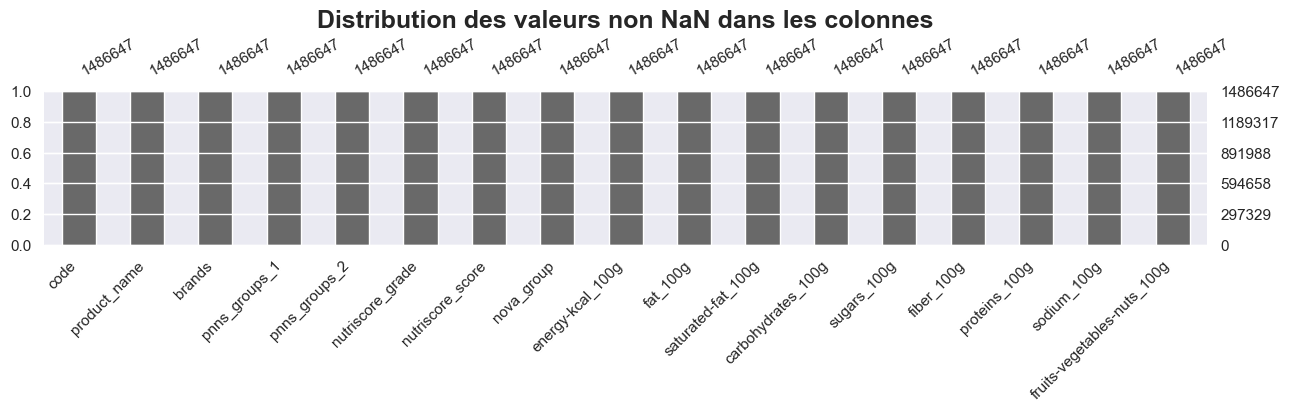

In [82]:
print('Percentage of NaN in the dataset equal to',
      sum(OFF_data.isna().sum()/OFF_data.shape[0]*100) / OFF_data.shape[1])
msno.bar(OFF_data, figsize=(15, 2), fontsize=11)
plt.title('Distribution des valeurs non NaN dans les colonnes', fontsize=18, fontweight='bold')
plt.xticks(rotation=30)
plt.show()

## <font id='Sec.6'> 6. Extracting the cleaned data

**To only keep the most important columns to the analysis, we down select again the columns. The final list of columns to keep:**

    'code', 'product_name', 'brands', 'pnns_groups_1', 'pnns_groups_2', 'nutriscore_grade', 'nutriscore_score', 'nova_group', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g', 'fruits-vegetables-nuts_100g'

In [83]:
columns_to_keep = ['code', 'product_name', 'brands', 'pnns_groups_1',
                   'pnns_groups_2', 'nutriscore_grade', 'nutriscore_score',
                   'nova_group', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g',
                   'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
                   'sodium_100g', 'fruits-vegetables-nuts_100g']
OFF_data = OFF_data[columns_to_keep]
print('The final number of columns equal to', OFF_data.shape[1],
      'out of the initial number of', initial_nbr_columns, 'columns.')
print('The final number of rows equal to', OFF_data.shape[0],
      'corresponding to', OFF_data.shape[0]/initial_nbr_rows*100, '% of the initial numbers of rows.')

The final number of columns equal to 17 out of the initial number of 197 columns.
The final number of rows equal to 1486647 corresponding to 55.14091347942407 % of the initial numbers of rows.


In [84]:
# Changing/simplifying the name of columns
OFF_data = OFF_data.rename(columns = {'energy-kcal_100g':'energy'})
OFF_data = OFF_data.rename(columns = {'fat_100g':'fat'})
OFF_data = OFF_data.rename(columns = {'saturated-fat_100g':'saturated_fat'})
OFF_data = OFF_data.rename(columns = {'carbohydrates_100g':'carbohydrates'})
OFF_data = OFF_data.rename(columns = {'sugars_100g':'sugars'})
OFF_data = OFF_data.rename(columns = {'fiber_100g':'fiber'})
OFF_data = OFF_data.rename(columns = {'proteins_100g':'proteins'})
OFF_data = OFF_data.rename(columns = {'sodium_100g':'sodium'})
OFF_data = OFF_data.rename(columns = {'fruits-vegetables-nuts_100g':'fruits_vegetables_nuts'})

In [85]:
OFF_data = OFF_data.reset_index(drop = True)
OFF_data.to_csv('OFF_data_cleaned.csv', sep='\t', index=False)